In [2]:
import pandas
import os
import sys
import itertools
import plotly
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from nilearn import plotting
from nilearn.datasets import MNI152_FILE_PATH
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, calinski_harabasz_score, silhouette_score
from sklearn.base import clone
from statsmodels.sandbox.stats.multicomp import multipletests
from importlib import reload
sys.path.insert(0,'/Users/jacobv/git/data_driven_pathology/')
#sys.path.insert(0,'/Users/jakevogel/git/data_driven_pathology')
import vogel_basc as vb
import CrossDecomp as XD
sys.path.insert(0,'/Users/jacobv/git/Hippocampus_AP_Axis/')
import HAP_Utils as hap

/Users/jacobv/jakepy/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/jacobv/jakepy/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
%matplotlib inline

# Prepare Data

In [4]:
corrected_data = pandas.read_pickle('/Users/jacobv/Science/PLS_GXP/txfer/corrected_AHBA_data.pk')

In [5]:
sorders = []
datas = []
for sid,data in corrected_data.items():
    sorder = pandas.concat([pandas.Series([sid]*len(data)),
                           pandas.Series(data.index.values)],
                          axis=1)
    sorder.columns = ['subject','samp_id']
    sorders.append(sorder)
    datas.append(data)

sample_order = pandas.concat(sorders)
sample_order.index = range(len(sample_order))
bigdf = pandas.concat(datas)
bigdf.index=range(len(bigdf))

In [6]:
corrected_data['9861']

gene_symbol      A1BG  A1BG-AS1       A2M     A2ML1   A3GALT2    A4GALT  \
sample_id                                                                 
0            0.301206  0.633459  0.524247  0.418119  0.354588  0.264215   
1            0.789466  0.423733  0.371010  0.236624  0.935364  0.710047   
2            0.950836  0.356655  0.597191  0.041786  0.607998  0.954603   
3            0.255668  0.211723  0.781888  0.370243  0.620974  0.137888   
4            0.282351  0.284394  0.859964  0.132408  0.454795  0.880341   
...               ...       ...       ...       ...       ...       ...   
941          0.418685  0.502129  0.174344  0.789632  0.531157  0.591213   
942          0.617213  0.491944  0.042616  0.650843  0.287727  0.296971   
943          0.736503  0.504146  0.216182  0.883115  0.473469  0.584772   
944          0.577938  0.534360  0.000000  0.795526  0.458121  0.263508   
945          0.667034  0.519516  0.324086  0.705290  0.265715  0.514612   

gene_symbol      AAAS      AACS   AADACL3     AADAT  ...      ZW10    ZWILCH  \
sample_id                                            ...                       
0            0.747265  0.896750  0.267889  0.854105  ...  0.664240  0.425123   
1            0.437137  0.661248  0.459832  0.432018  ...  0.091802  0.756656   
2            0.204959  0.408170  0.408236  0.250875  ...  0.620293  0.678288   
3            0.034473  0.068002  0.885394  0.148016  ...  0.240219  0.131628   
4            0.479368  0.065681  0.682845  0.422405  ...  0.402900  0.326117   
...               ...       ...       ...       ...  ...       ...       ...   
941          0.808100  0.250078  0.655301  0.028278  ...  0.646091  0.388759   
942          0.862281  0.261557  0.412458  0.003495  ...  0.785042  0.493538   
943          0.745361  0.212006  0.331093  0.012549  ...  0.717764  0.645508   
944          0.872686  0.335038  0.768923  0.000000  ...  0.823130  0.581207   
945          0.708821  0.246847  0.287664  0.000726  ...  0.797366  0.597179   

gene_symbol     ZWINT      ZXDA      ZXDB      ZXDC    ZYG11B       ZYX  \
sample_id                                                                 
0            0.393411  0.539312  0.441774  0.344128  0.790665  0.750759   
1            0.240631  0.915214  0.304052  0.508392  0.569169  0.770941   
2            1.000000  0.136651  0.060707  0.880952  0.438016  0.549799   
3            0.321255  0.005255  0.007859  0.908355  0.051453  0.286382   
4            0.457908  0.446117  0.031938  0.630605  0.132883  0.134859   
...               ...       ...       ...       ...       ...       ...   
941          0.193391  0.863673  0.994125  0.888889  0.763966  0.745088   
942          0.250078  0.785626  0.899433  0.927567  0.734708  0.742931   
943          0.145462  0.747295  0.985674  0.940601  0.645004  0.845900   
944          0.177268  0.865495  0.987623  0.826149  0.808622  0.842181   
945          0.152275  0.804542  0.976154  0.894875  0.785602  0.858955   

gene_symbol     ZZEF1      ZZZ3  
sample_id                        
0            0.548501  0.335783  
1            0.568334  0.889131  
2            0.148812  0.406152  
3            0.527082  0.017642  
4            0.263702  0.678706  
...               ...       ...  
941          0.738758  0.228569  
942          0.702347  0.146631  
943          0.801701  0.309588  
944          0.745001  0.203189  
945          0.730250  0.252777  

[904 rows x 15633 columns]

In [7]:
bigdf.shape

(3466, 15633)

In [8]:
wdir = '/Users/jacobv/Science/PLS_GXP/txfer/'
probes = pandas.read_csv(os.path.join(wdir,'Probes.csv'))
gdf = pandas.read_csv(os.path.join(wdir,'gxp_correlation_wholebrain_results_NEW.csv'))

In [9]:
new_gdf = []
for subject in sample_order.subject.unique():
    sampids = sample_order[sample_order.subject==subject].samp_id.values+1
    #shared = set(gdf['sample']) & set(sampids)
    selection = gdf[(gdf.donor==int(subject)) &\
                    (gdf['sample'].isin(sampids))]
    new_gdf.append(selection)
old_gdf = pandas.DataFrame(gdf,copy=True)
gdf = pandas.concat(new_gdf)

In [10]:
gdf.index = range(len(gdf.index))

#### Reduce to mouse genes

In [11]:
homo = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/Mouse/MouseHumanComp_Orig.csv',
                      index_col=0)
homo.head()

MouseC1   MouseC2   MouseC3   HumanC1   HumanC2   HumanC3
NRG2     0.006967  0.012442  0.005642  0.006455 -0.002230  0.013806
CAMTA1   0.014550  0.024123  0.051402  0.006785 -0.009396 -0.003544
DCUN1D4  0.010135 -0.005134  0.002363  0.001091 -0.000446  0.004482
NFXL1    0.003693 -0.000286  0.003713  0.008827  0.009024  0.000342
CPNE7   -0.010815 -0.047134  0.018085 -0.009136  0.004629 -0.007924

In [12]:
bigdf = bigdf[homo.index]

In [13]:
bigdf.shape

(3466, 1576)

In [14]:
too_few = [x for x in gdf.structure_acronym.value_counts().index if gdf.structure_acronym.value_counts()[x] < 2]
gdf.loc[:,'new_structure_acronym'] = ['Other' if x in too_few else x for x in gdf.structure_acronym.values]

In [15]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)

0.8804383965294775

In [16]:
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf))

In [17]:
gdf.loc[:,'abs_mni_nlin_x'] = abs(gdf.mni_nlin_x.values)
tr,te = train_test_split(pca_tfm, stratify=gdf.new_structure_acronym.values, random_state=123)
tr_y = gdf.loc[tr.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]

# Train model

#### Cross-validation w/ repeated cv for CIs

In [18]:
from sklearn.cross_decomposition import PLSCanonical, PLSSVD
from sklearn.model_selection import KFold

ncs = 3
nc_chooser = pandas.DataFrame(index = range(ncs*3), columns = ['nc', 'estimator', 'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), 
                  'CCA': CCA(n_components=nc),
                 'PLSC': PLSCanonical(n_components=nc)}
#    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        for it in range(10):
            cv=KFold(n_splits=10,shuffle=True,random_state=123+it)
            pred = cross_val_predict(estimator, tr, tr_y, 
                                    groups = gdf.loc[tr.index].slab_type, 
                                     cv=cv)
            nc_chooser.loc[i, 'r2'] = r2_score(y_true=tr_y, y_pred=pred)
            nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=tr_y, y_pred=pred)
            nc_chooser.loc[i, 'estimator'] = lab
            nc_chooser.loc[i,'nc'] = nc
            nc_chooser.loc[i,'iter'] = it
            i+=1

1
2
3


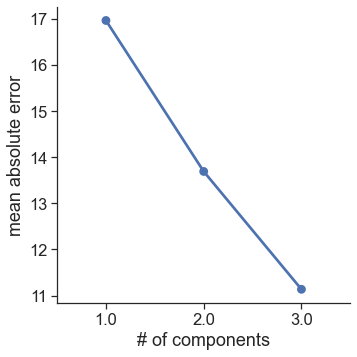

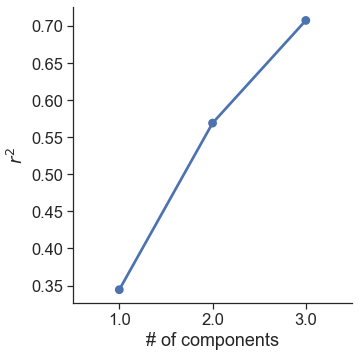

In [21]:
sns.set(font_scale=1.5)
sns.set_style('ticks')

sns.catplot(x = 'nc', y='mae', #hue = 'estimator', 
               data=nc_chooser[nc_chooser.estimator=='PLSR'],aspect=1,kind='point')
plt.ylabel('mean absolute error')
plt.xlabel('# of components')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/estimator_selection_cv_mae_rkf.pdf', 
#             bbox_inches='tight')
plt.show()

sns.catplot(x = 'nc', y='r2', #hue = 'estimator', 
               data=nc_chooser[nc_chooser.estimator=='PLSR'],
               aspect=1,kind='point')
plt.ylabel('$r^{2}$')
plt.xlabel('# of components')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/estimator_selection_cv_r2_rkf.pdf', 
#             bbox_inches='tight')
plt.show()

#### Cross-validation w/ bootstrapping for CIs

In [26]:
from sklearn.cross_decomposition import PLSCanonical, PLSSVD
from sklearn.model_selection import KFold

ncs = 3
nc_chooser = pandas.DataFrame(index = range(ncs*3), 
                              columns = ['nc', 'estimator', 
                                         'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), 
                  'CCA': CCA(n_components=nc),
                 'PLSC': PLSCanonical(n_components=nc)}
#    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        for it in range(100):
            nind = np.random.choice(tr.index,len(tr.index))
            pred = cross_val_predict(estimator, tr.loc[nind],
                                     tr_y.loc[nind],
                                    groups = gdf.loc[nind].slab_type, 
                                     cv=10)
            nc_chooser.loc[i, 'r2'] = r2_score(y_true=tr_y.loc[nind],
                                               y_pred=pred)
            nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=tr_y.loc[nind],
                                                           y_pred=pred)
            nc_chooser.loc[i, 'estimator'] = lab
            nc_chooser.loc[i,'nc'] = nc
            nc_chooser.loc[i,'iter'] = it
            i+=1

1
2
3


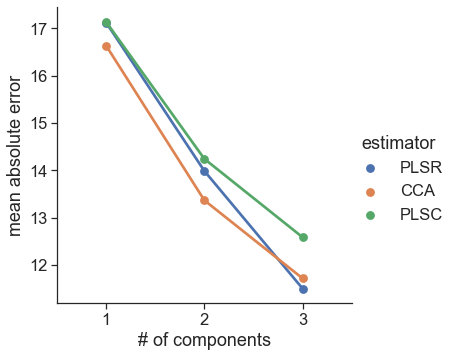

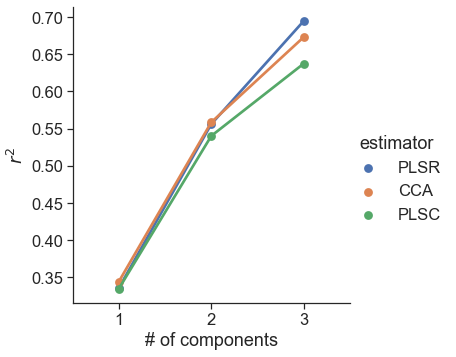

In [27]:
sns.set(font_scale=1.5)
sns.set_style('ticks')

sns.catplot(x = 'nc', y='mae', hue = 'estimator', 
               data=nc_chooser,aspect=1,kind='point')
plt.ylabel('mean absolute error')
plt.xlabel('# of components')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/estimator_selection_cv_mae_bs_100.pdf', 
#            bbox_inches='tight')
plt.show()

sns.catplot(x = 'nc', y='r2', hue = 'estimator', 
               data=nc_chooser[nc_chooser.nc<5],
               aspect=1,kind='point')
plt.ylabel('$r^{2}$')
plt.xlabel('# of components')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/estimator_selection_cv_r2_bs_100.pdf', 
#             bbox_inches='tight')
plt.show()

In [28]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)

PLSRegression(n_components=3)

In [62]:
# from importlib import reload
# reload(XD)

In [128]:
# results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y, n_iterations=1000,
#                                           metric=mean_absolute_error)

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


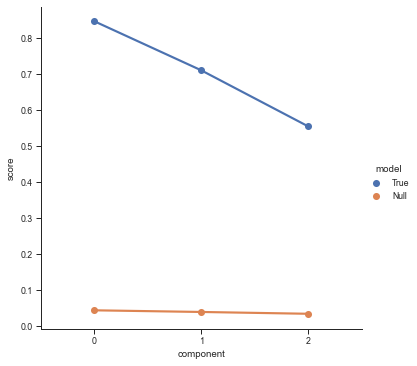

component 0: p = 0.001  ***
component 1: p = 0.001  ***
component 2: p = 0.001  ***


In [29]:
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y, n_iterations=1000)

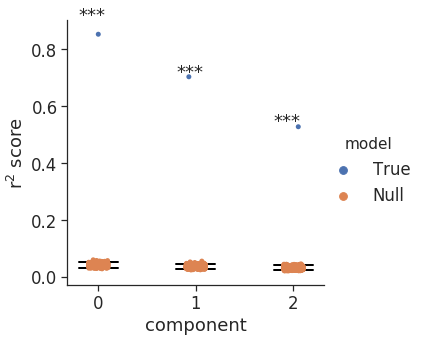

In [64]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
sns.catplot(x='component', y='score', hue='model', data=results)
plt.text(-0.20,0.9,'***')
plt.text(0.80,0.7,'***')
plt.text(1.80,0.53,'***')
plt.ylabel('r$^2$ score')
for c in range(len(results.component.unique())):
    cvals = results[(results.model=='Null')&(results.component==c)
                ].score.sort_values().values
    cmin = cvals[25]
    cmax = cvals[975]
    plt.plot([c-.2,c+.2],[cmin,cmin],lw=2,c='black')
    plt.plot([c-.2,c+.2],[cmax,cmax],lw=2,c='black')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/sig_componentsTR.pdf',
#              bbox_inches='tight')

# Evaluate model

In [22]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)

PLSRegression(n_components=3)

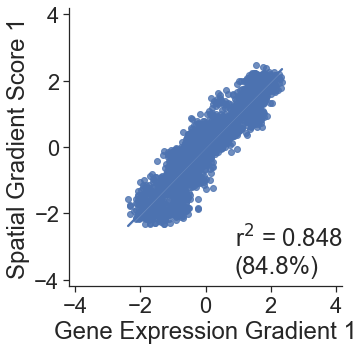

r2 = 0.8475303567070654, percent of total = 0.8475303567070654


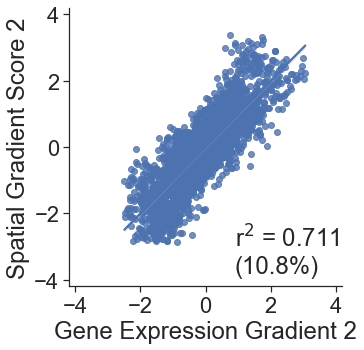

r2 = 0.7108877157878533, percent of total = 0.10838879644750303


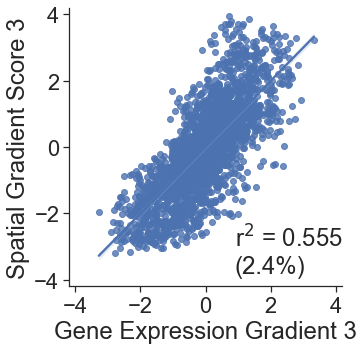

r2 = 0.5547687136926409, percent of total = 0.024454674702922355


In [23]:
# plot component scores
sns.set_context('notebook',font_scale=2)
total = 1
leftover = 1
for i in range(pls_mod.n_components):
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = (leftover * r2)
    exp_perc = explained * 100
    plt.close()
    plotr = pandas.concat([pandas.Series(pls_mod.x_scores_[:,i]),
                          pandas.Series(pls_mod.y_scores_[:,i])],
                         axis=1)
    plotr.columns = ['x','y']
    g=sns.lmplot(x='x', y='y',data=plotr)
    plt.xlim(-4.2,4.2)
    plt.ylim(-4.2,4.2)
    g.set(xticks=[-4,-2,0,2,4])
    plt.xlabel('Gene Expression Gradient %i'%(i+1))
    plt.ylabel('Spatial Gradient Score %i'%(i+1))
    plt.text(.9,-3.8,'r$^2$ = %s \n(%s%%)'%(round(r2,3),round(exp_perc,1)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/principal_correlation_%s.pdf'%i,
#                bbox_inches='tight')
    plt.show()
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover -= explained


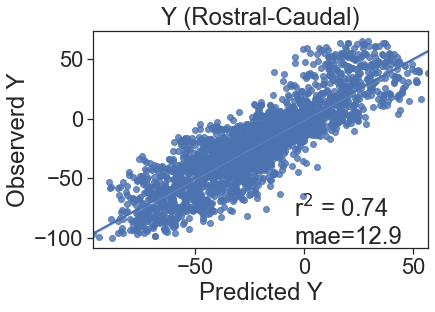

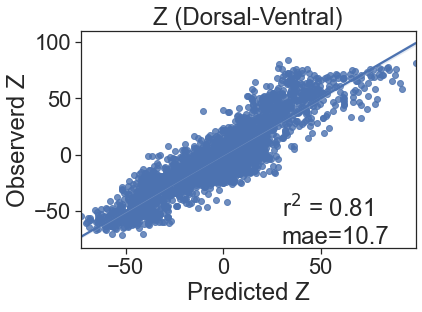

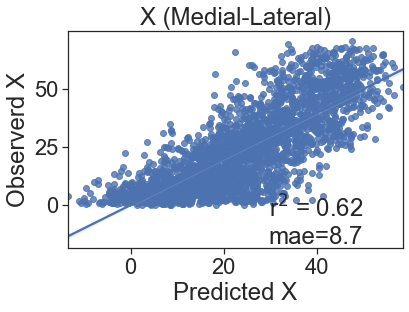

In [24]:
# plot model fit
pred = pls_mod.predict(tr)
labs = dict(zip(['Y','Z','X'],
                ['Rostral-Caudal',
                  'Dorsal-Ventral',
                  'Medial-Lateral']))

for i in range(tr_y.shape[-1]):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    label = tr_y.columns[i][-1].upper()
    sns.regplot(x=pred[:,i], y=tr_y[tr_y.columns[i]],
                #color = colos[label]
               )
    plt.title('%s (%s)'%(label,labs[label]))
    plt.xlabel('Predicted %s'%label)
    plt.ylabel('Observerd %s'%label)
    
#     tx = np.max(pred[:,i]) - np.min(pred[:,i]) * .4
#     tx = np.min(pred[:,i]) + tx
#     ty = np.max(tr_y[tr_y.columns[i]]
#                ) -np.min(tr_y[tr_y.columns[i]]) * -.5
#     ty = np.min(tr_y[tr_y.columns[i]]) + ty
    r2 = stats.pearsonr(pred[:,i], tr_y[tr_y.columns[i]])[0]**2
    mae = mean_absolute_error(pred[:,i], tr_y[tr_y.columns[i]])
    plt.text(0.6,0.02,
             'r$^2$ = %s \nmae=%s'%(round(r2,2),round(mae,1)),
            transform=ax.transAxes)
#     plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/TestRes_%s.pdf'%label,
#                bbox_inches='tight')
    plt.show()


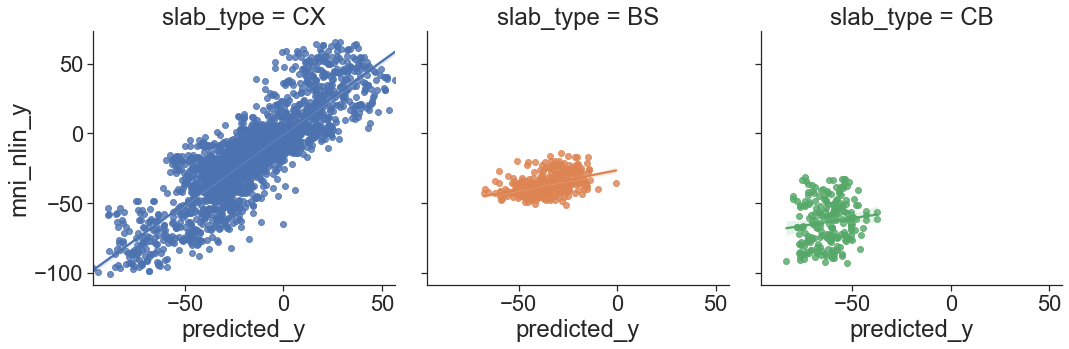

CX r2 =0.7225290896843138
CX mae =13.526677267444468
BS r2 =0.1833964522069339
BS mae =8.304851541397857
CB r2 =0.01497515178047492
CB mae =14.530195536027643


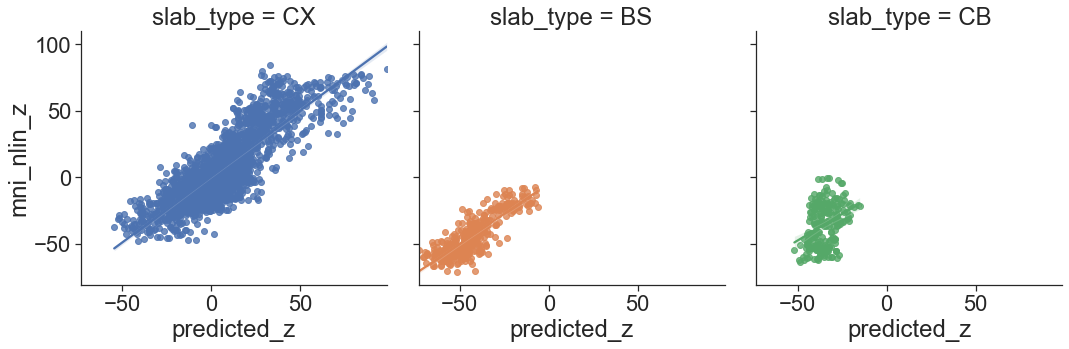

CX r2 =0.7183359824313298
CX mae =11.194566120192802
BS r2 =0.721292110012505
BS mae =6.529364757609409
CB r2 =0.12039233881367022
CB mae =12.506395080796267


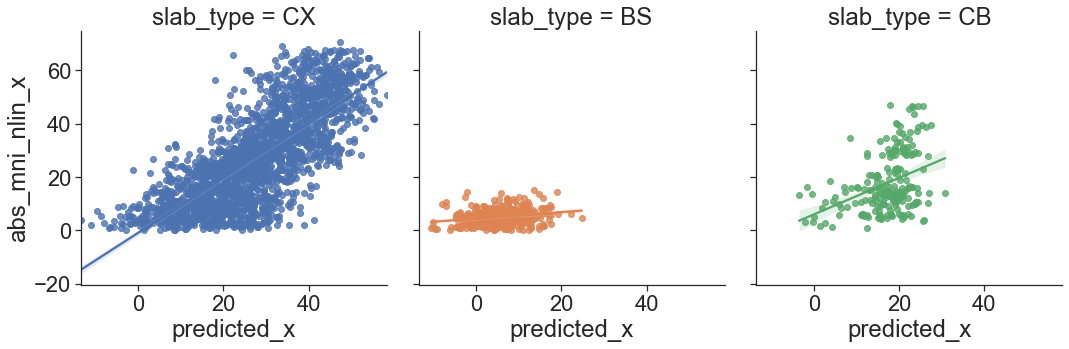

CX r2 =0.5671090254451031
CX mae =9.36675971049205
BS r2 =0.055115236984404056
BS mae =4.7761936643493055
CB r2 =0.1450887162080406
CB mae =8.533354266783915


In [25]:
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(pred, index=tr_y.index), tr_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z','predicted_x'] + tr_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[tr.index,'slab_type']
n_components = tr_y.shape[-1]
for i in range(n_components):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+n_components], 
               col = 'slab_type', data = preds_df,hue='slab_type')
    #plt.title(preds_df.columns[i+n_components])
    plt.show()
    for slab in preds_df.slab_type.unique():
        if not pandas.notnull(slab):
            continue
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+n_components]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i+n_components]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

# Test model

In [26]:
pal=sns.color_palette('nipy_spectral',n_colors=12)
colos = dict(zip(['Y','Z','X'],
                [pal[5],pal[3],pal[-1]]
                ))
pal

[(0.4993470588235294, 0.0, 0.5659960784313726),
 (0.0, 0.0, 0.6784647058823529),
 (0.0, 0.2928313725490196, 0.8667),
 (0.0, 0.6078470588235294, 0.8431705882352941),
 (0.0, 0.6667, 0.575150980392157),
 (0.0, 0.633978431372549, 0.0),
 (0.0, 0.8326960784313726, 0.0),
 (0.2300549019607843, 1.0, 0.0),
 (0.9097705882352941, 0.9411470588235294, 0.0),
 (1.0, 0.7254901960784318, 0.0),
 (1.0, 0.03529411764705881, 0.0),
 (0.8326960784313726, 0.0, 0.0)]

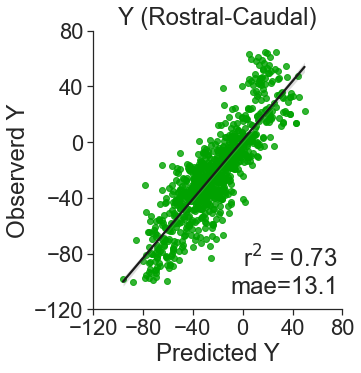

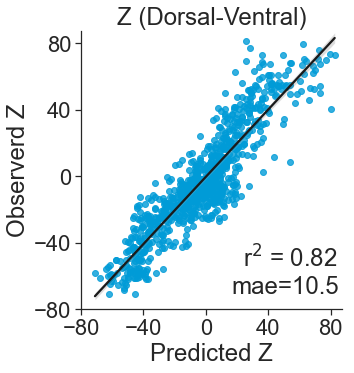

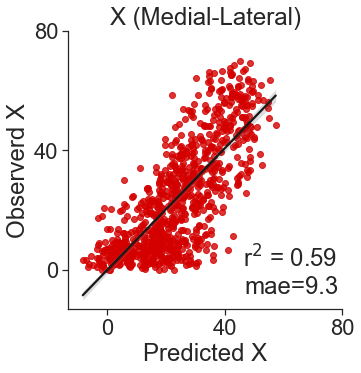

In [27]:
# plot model fit
dims = ['Y','Z','X']
labs = dict(zip(dims,['Rostral-Caudal',
                      'Dorsal-Ventral',
                      'Medial-Lateral']))
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
#     fig = plt.figure(figsize=(6,4))
#     ax = fig.add_subplot(111)
    label = te_y.columns[i][-1].upper()
    plotr = pandas.concat([pandas.Series(te_pred[:,i]),
                          pandas.Series(te_y[te_y.columns[i]].values)],
                         axis=1)
    plotr.columns = ['x','y']
    g=sns.lmplot(x='x', y='y',data=plotr,
                 scatter_kws={'color':colos[label]},
                 line_kws={'color':'k'}
                )
    pmax = np.max(plotr.max().values)
    pmin = np.min(plotr.min().values)
    incr = 40
    tmin = int(round((pmin/incr))*incr)
    tmax = int(round((pmax/incr))*incr) + 1
    trange = list(range(tmin,tmax,incr))
    plt.title('%s (%s)'%(label,labs[label]))
    plt.xlabel('Predicted %s'%label)
    plt.ylabel('Observerd %s'%label)
    plt.xlim(pmin-5,pmax+5)
    plt.ylim(pmin-5,pmax+5)
    g.set(xticks=trange,yticks=trange)
    r2 = stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]])[0]**2
    mae = mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]])
    plt.text(0.85,0.2,
             'r$^2$ = %s \nmae=%s'%(round(r2,2),round(mae,1)),
            transform=ax.transAxes,horizontalalignment='right')
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/TestRes_%s.pdf'%label,
#                bbox_inches='tight')
    plt.show()


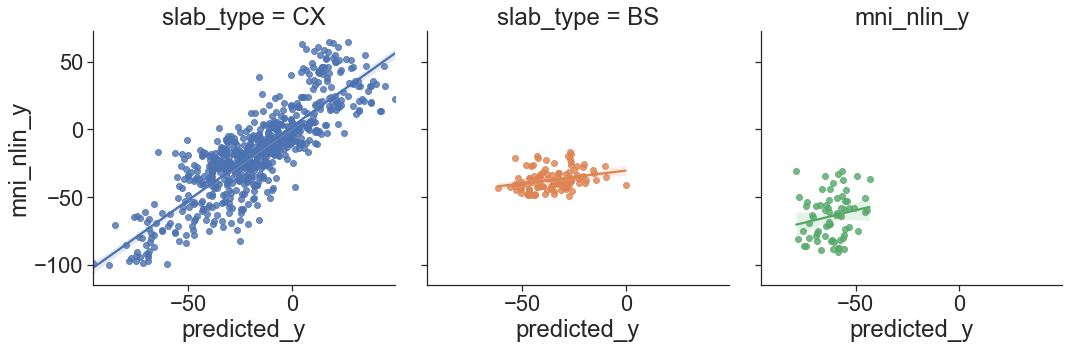

CX r2 =0.7150379241176913
CX mae =13.709906319044357
BS r2 =0.0823864889589695
BS mae =9.368871066939159
CB r2 =0.03431922501659999
CB mae =13.959562826665033


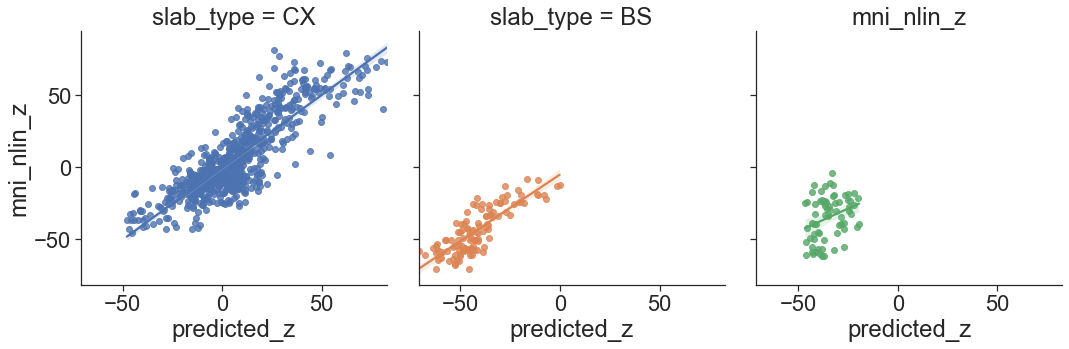

CX r2 =0.7306933528800997
CX mae =10.82142596057841
BS r2 =0.6877009639578
BS mae =7.452092291453043
CB r2 =0.09451302386363647
CB mae =12.110479822504615


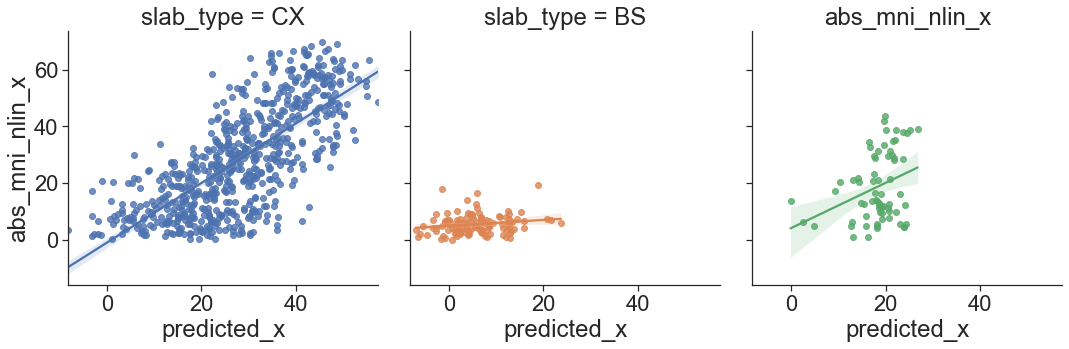

CX r2 =0.5358903941968856
CX mae =9.988273159404628
BS r2 =0.03395313482491035
BS mae =5.0060833200155495
CB r2 =0.10585267611612037
CB mae =10.081093901210515


In [28]:
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(te_pred, index=te_y.index), te_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z', 'predicted_x'] + te_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[te.index,'slab_type']
n_components = te_y.shape[-1]
for i in range(n_components):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+n_components], hue = 'slab_type', 
               col = 'slab_type', data = preds_df)
#     plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/%s_by_slabtype.pdf'%preds_df.columns[i],
#               bbox_inches = 'tight')
    plt.title(preds_df.columns[i+n_components])
    plt.show()
    for slab in preds_df.slab_type.unique():
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+n_components]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i+n_components]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

In [29]:
pls_mod = PLSRegression(n_components=3)
full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


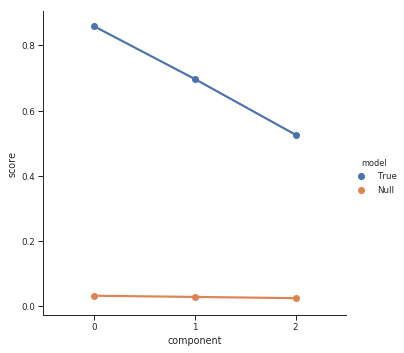

component 0: p = 0.001  ***
component 1: p = 0.001  ***
component 2: p = 0.001  ***


In [72]:
# significant components?
results, comp_sig = XD.evaluate_components(pls_mod, pca_tfm, full_y, n_iterations=1000)

/home/users/jvogel/gxp/lib/python3.5/site-packages/seaborn/categorical.py:3672: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



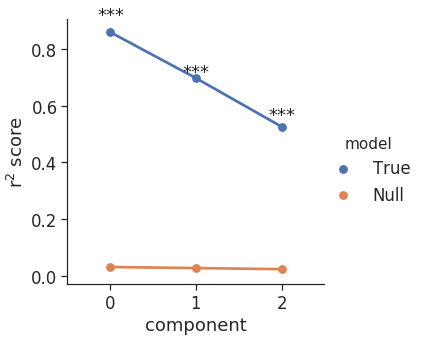

In [73]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
sns.factorplot(x='component', y='score', hue='model', data=results)
plt.text(-0.15,0.9,'***')
plt.text(0.85,0.7,'***')
plt.text(1.85,0.55,'***')
plt.ylabel('r$^2$ score')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/FULLMOD_sig_components.pdf',
#            bbox_inches='tight')
plt.show()

# Build and evaluate model on all data

In [30]:
pls_mod = PLSRegression(n_components=3)
full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

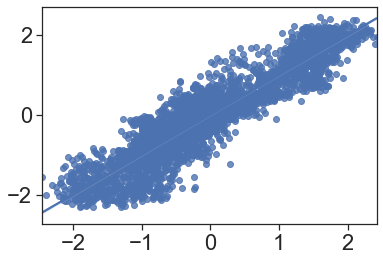

r2 = 0.8523342082793532, percent of total = 0.8523342082793532


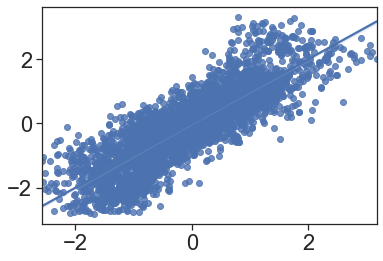

r2 = 0.7164002003495964, percent of total = 0.10578780277345311


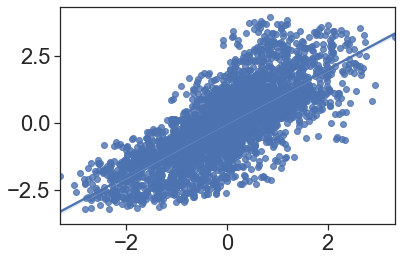

r2 = 0.5522263648890645, percent of total = 0.02312612960517317


In [31]:
pls_mod.fit(pca_tfm, gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']])
# plot component scores
total = 1
leftover = 1
for i in range(pls_mod.n_components):
    plt.close()
    sns.regplot(x=pls_mod.x_scores_[:,i], y=pls_mod.y_scores_[:,i])
    plt.show()
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = leftover * r2
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover = leftover - explained

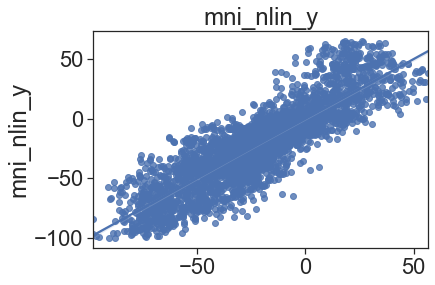

(0.8646256449531966, 0.0)
12.758949858969972


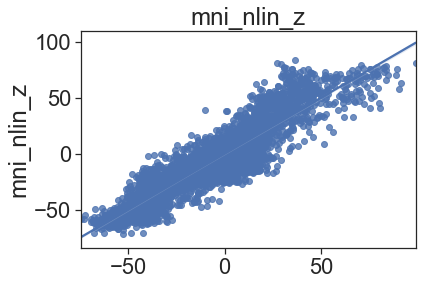

(0.9061294297566178, 0.0)
10.48704017679714


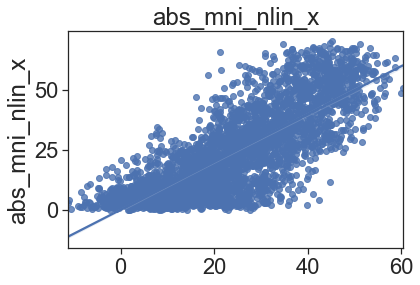

(0.7880752342008859, 0.0)
8.724978223042065


In [32]:
# plot model fit
pred = pls_mod.predict(pca_tfm)
for i in range(full_y.shape[-1]):
    plt.close()
    sns.regplot(x=pred[:,i], y=full_y[full_y.columns[i]])
    plt.title(full_y.columns[i])
    plt.show()
    print(stats.pearsonr(pred[:,i], full_y[full_y.columns[i]]))
    print(mean_absolute_error(pred[:,i], full_y[full_y.columns[i]]))

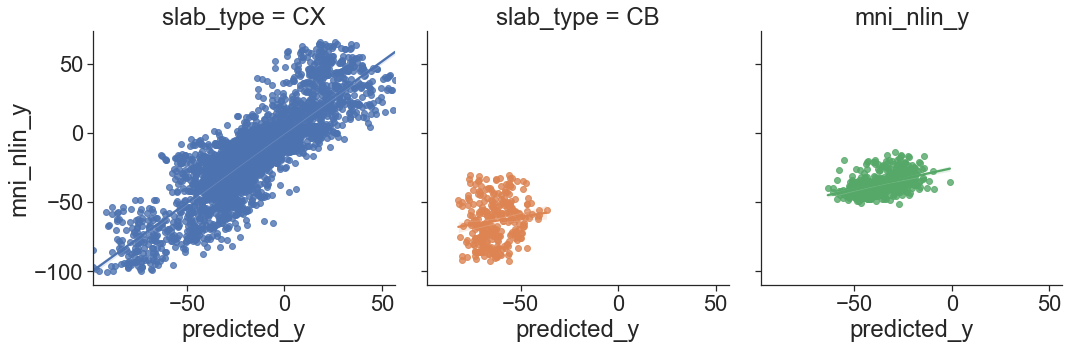

CX r2 =0.725678124419087
CX mae =46.99775869624787
CB r2 =0.016422323009297357
CB mae =81.01312946046397
BS r2 =0.2015883451352343
BS mae =41.43640079746462


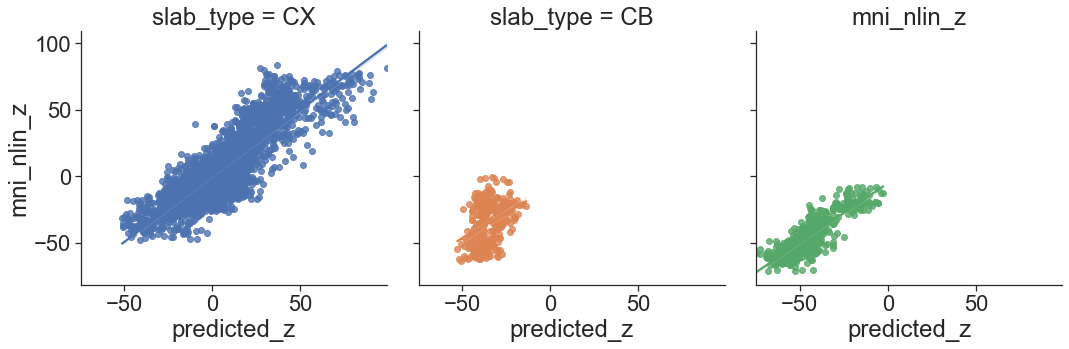

CX r2 =0.7287259116317367
CX mae =36.991538715701545
CB r2 =0.13130572728184853
CB mae =29.449196038865505
BS r2 =0.7439925038162872
BS mae =11.208592582657387


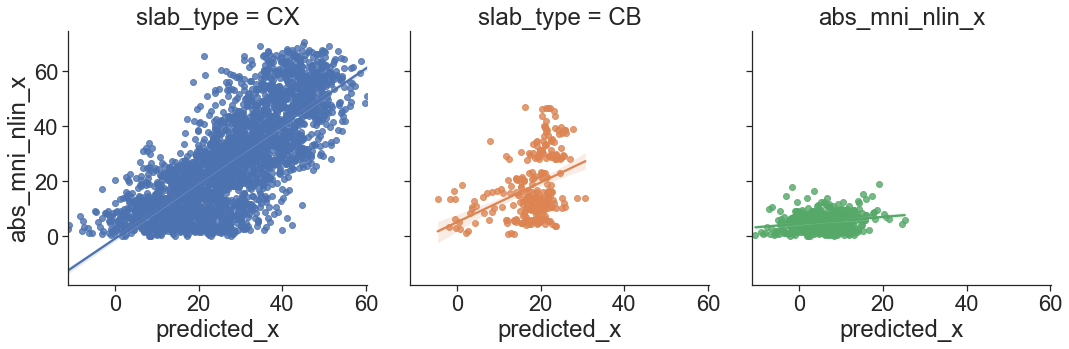

CX r2 =0.5649758710853617
CX mae =31.045189842135517
CB r2 =0.14431690305457753
CB mae =53.258283803589094
BS r2 =0.05348701610448557
BS mae =48.85178192745672


In [33]:
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(pred, index=full_y.index), full_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z', 'predicted_x'] + full_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[pca_tfm.index,'slab_type']
n_components = full_y.shape[-1]
for i in range(n_components):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+n_components], 
               col = 'slab_type', data = preds_df, hue='slab_type')
    plt.title(preds_df.columns[i+n_components])
    plt.show()
    for slab in preds_df.slab_type.unique():
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+n_components]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i+2]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

# Visualize predictions

In [34]:
preds_df.loc[:,'structure'] = gdf.structure_acronym.values

In [35]:
g2=pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/MAIN_gcx_wholebrain_info_W_BRAIN_DIVISIONS.csv',
                  index_col=0)

In [36]:
g2 = g2.loc[gdf[gdf.columns[0]].values]

In [37]:
bd2 = ['Temporal' if x == 'Limbic' else\
      'Subcortex' if x in ['Thalamus','Striatum',
                           'Hypothalamus','Forebrain',
                           'Other_Dien'] else\
      'Brainstem' if x in ['Medulla','Pons',
                           'Tegmentum','Tectum'] else\
      'Frontal' if x in ['Anterior_Cingulate','Insula'] else\
      'Parietal' if x == 'Posterior_Cingulate' else\
      'Cerebellum' if x == 'DCN' else\
      x for x in g2.brain_divison.values]
g2.loc[:,'BD2'] = bd2

/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-115.0, 75.0)

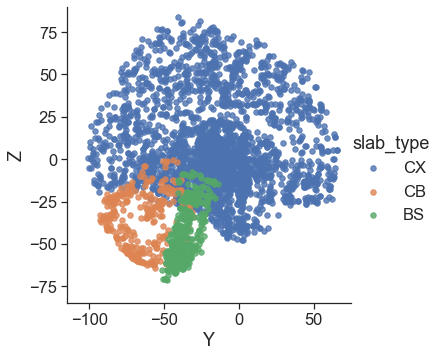

In [45]:
sns.set_context('notebook',font_scale=1.5)
sns.lmplot('mni_nlin_y', 'mni_nlin_z', hue = 'slab_type', data=gdf, fit_reg=False, 
           scatter_kws={"s": 30})
plt.xlabel('Y')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-115,75)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/brain_plot_YZ.pdf',
#            bbox_inches='tight')

(-115.0, 75.0)

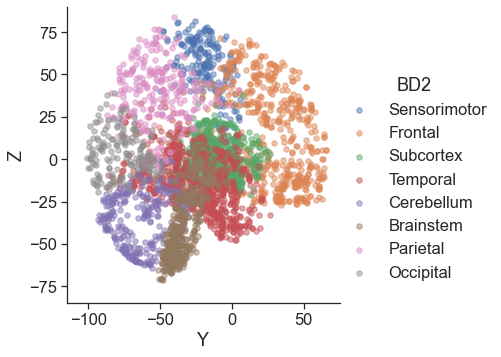

In [46]:
sns.set_context('notebook',font_scale=1.5)
sns.lmplot(x='mni_nlin_y',y='mni_nlin_z', hue = 'BD2', data=g2, 
           fit_reg=False, 
           scatter_kws={"s": 30,'alpha':0.5})
plt.xlabel('Y')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-115,75)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/brain_plot_YZ_div.pdf',
#            bbox_inches='tight')

(-115.0, 75.0)

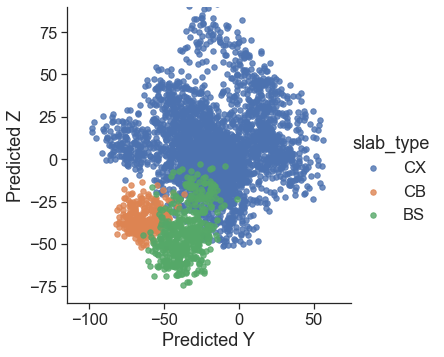

In [47]:
sns.lmplot(x='predicted_y', y='predicted_z', hue = 'slab_type', 
           data=preds_df, 
           fit_reg=False, scatter_kws={"s": 30})
plt.xlabel('Predicted Y')
plt.ylabel('Predicted Z')
plt.ylim(-85,90)
plt.xlim(-115,75)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/brain_plot_YZ_pred.pdf',
#            bbox_inches='tight')

In [48]:
preds_df.loc[:,'BD2'] = bd2

(-115.0, 75.0)

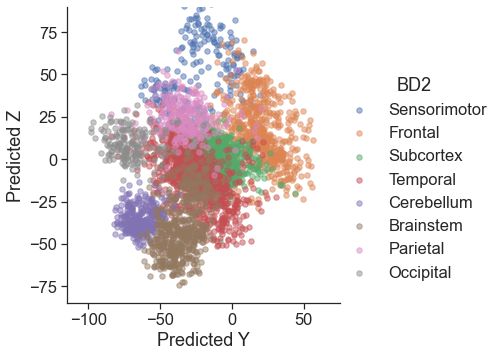

In [49]:
sns.lmplot(x='predicted_y', y='predicted_z', hue = 'BD2', data=preds_df, 
           fit_reg=False, 
           scatter_kws={"s": 30,'alpha':0.5})
plt.xlabel('Predicted Y')
plt.ylabel('Predicted Z')
plt.ylim(-85,90)
plt.xlim(-115,75)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/brain_plot_YZ_pred_div.pdf',
#            bbox_inches='tight')

In [50]:
preds_df.loc[:,'error_y'] = abs(preds_df.predicted_y.values -\
                                preds_df.mni_nlin_y.values)
preds_df.loc[:,'error_z'] = abs(preds_df.predicted_z.values -\
                                preds_df.mni_nlin_z.values)
preds_df.loc[:,'error_x'] = abs(preds_df.predicted_x.values -\
                                preds_df.abs_mni_nlin_x.values)
preds_df.loc[:,'total_error'] = preds_df[['error_y',
                                          'error_z',
                                          'error_x']].mean(1).values
ecols = [x for x in preds_df.columns if 'error' in x]
for ecol in ecols:
    cut = pandas.cut(preds_df[ecol],10)
    code = dict(zip(np.unique(cut),range(1,len(np.unique(cut))+1)))
    preds_df.loc[:,'%s_cat'%ecol] = [code[x] for x in cut]

In [63]:
code

{Interval(0.111, 4.274, closed='right'): 1,
 Interval(4.274, 8.395, closed='right'): 2,
 Interval(8.395, 12.516, closed='right'): 3,
 Interval(12.516, 16.638, closed='right'): 4,
 Interval(16.638, 20.759, closed='right'): 5,
 Interval(20.759, 24.881, closed='right'): 6,
 Interval(24.881, 29.002, closed='right'): 7,
 Interval(29.002, 33.124, closed='right'): 8,
 Interval(33.124, 37.245, closed='right'): 9,
 Interval(37.245, 41.366, closed='right'): 10}

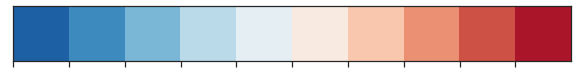

In [64]:
sns.palplot(sns.color_palette('RdBu_r',10))
plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_error_colors.pdf',
            bbox_inches='tight')

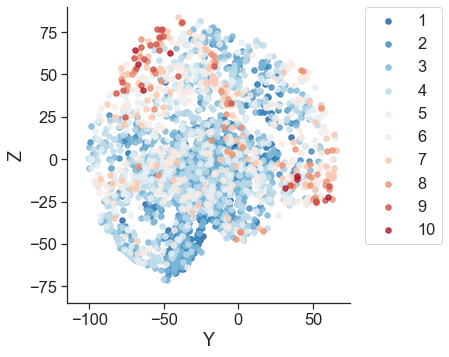

In [52]:
sns.lmplot(x='mni_nlin_y', y='mni_nlin_z', 
           hue = 'total_error_cat',legend=False, 
           data=preds_df, fit_reg=False, 
           scatter_kws={"s": 30},
          palette='RdBu_r')
plt.xlabel('Y')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-115,75)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/brain_plot_error_YZ.pdf',
#             bbox_inches='tight')

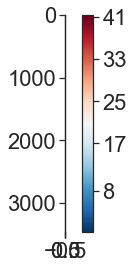

In [257]:
fig, ax = plt.subplots()
cax = ax.imshow(preds_df.total_error.values.reshape(-1,1), 
                interpolation='none', cmap='RdBu_r')
cbar = fig.colorbar(cax)
cbar.set_ticks(newticks)

([<matplotlib.axis.YTick at 0x13795c940>,
 [Text(0, -100.0, '−100'),
  Text(0, -75.0, '−75'),
  Text(0, -50.0, '−50'),
  Text(0, -25.0, '−25'),
  Text(0, 0.0, '0'),
  Text(0, 25.0, '25'),
  Text(0, 50.0, '50')])

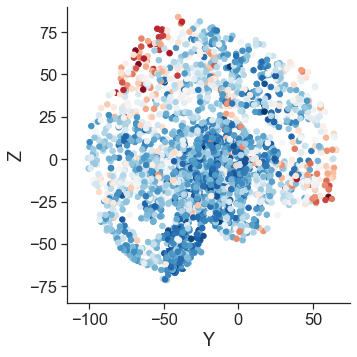

In [53]:
import matplotlib.colors
cmap = sns.color_palette('RdBu_r',as_cmap=True)
norm = matplotlib.colors.Normalize(vmin=preds_df.total_error.min(), 
                                   vmax=preds_df.total_error.max())
cscale = cmap(norm(preds_df.total_error.values))

g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z', 
              legend=True, 
               data=preds_df, fit_reg=False, 
               scatter_kws={"s": 30,'color':cscale},
              palette='RdBu_r')
plt.xlabel('Y')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-115,75)
plt.xticks([-100,-50,0,50])
plt.yticks(list(range(-75,76,25)))
# plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_error_YZ.pdf',
#             bbox_inches='tight')

# # colorbar
# a = np.array([[0,1]])
# plt.figure(figsize=(.2, 5))
# img = plt.imshow(a, cmap="RdBu_r")
# plt.gca().set_visible(False)
# cax = plt.axes([0.1, 0.2, 0.8, 0.6])
# cbar = plt.colorbar(orientation="vertical", cax=cax)
# newticks = [int(round(norm.inverse(x))) for x in cbar.get_ticks()]
# cbar.set_ticks(cbar.get_ticks())
# cbar.set_ticklabels(newticks)
# plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_error_YZ_cbar.pdf',
#             bbox_inches='tight')




In [266]:
# code

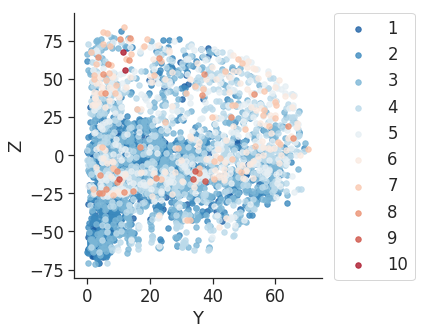

In [101]:
sns.lmplot('abs_mni_nlin_x', 'mni_nlin_z', 
           hue = 'total_error_cat',legend=False, 
           data=preds_df, fit_reg=False, 
           scatter_kws={"s": 30},
          palette='RdBu_r')
plt.xlabel('Y')
plt.ylabel('Z')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/brain_plot_error_XZ.pdf',
#             bbox_inches='tight')

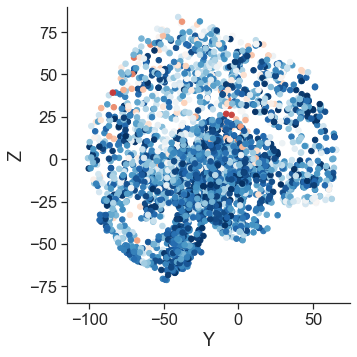

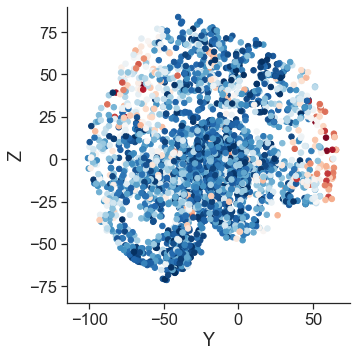

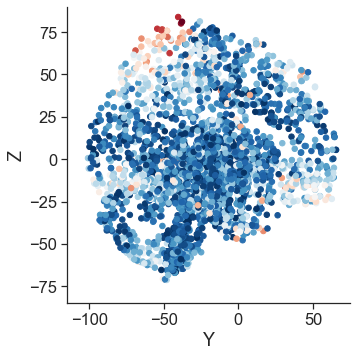

In [54]:
cmap = sns.color_palette('RdBu_r',as_cmap=True)

for col in ['error_x','error_y','error_z']:
    c = col[-1].upper()
    norm = matplotlib.colors.Normalize(vmin=preds_df[col].min(), 
                                       vmax=preds_df[col].max())
    cscale = cmap(norm(preds_df[col].values))

    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z', 
                  legend=True, 
                   data=preds_df, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_%serror_YZ.pdf'%c,
#                bbox_inches='tight')

#     # colorbar
#     a = np.array([[0,1]])
#     plt.figure(figsize=(.2, 5))
#     img = plt.imshow(a, cmap="RdBu_r")
#     plt.gca().set_visible(False)
#     cax = plt.axes([0.1, 0.2, 0.8, 0.6])
#     cbar = plt.colorbar(orientation="vertical", cax=cax)
#     newticks = [int(round(norm.inverse(x))) for x in cbar.get_ticks()]
#     cbar.set_ticks(cbar.get_ticks())
#     cbar.set_ticklabels(newticks)
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_%serror_YZ_cbar.pdf'%c,
#                bbox_inches='tight')
    
    plt.show()




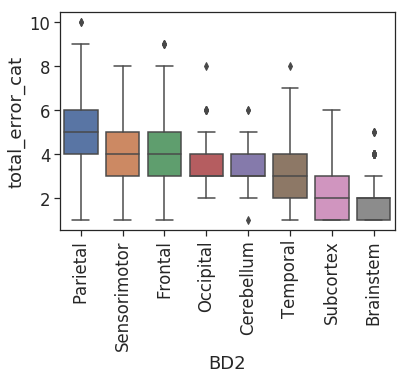

In [52]:
order = pandas.pivot_table(preds_df,index='BD2',
                           values='total_error_cat'
                          ).sort_values('total_error_cat',
                                        ascending=False).index
g = sns.boxplot(x='BD2',y='total_error_cat',data=preds_df,order=order)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/brain_plot_error_by_region.pdf',
            bbox_inches='tight')

In [71]:
ecol = 'error_x'
cut = pandas.cut(preds_df[ecol],10)
code = dict(zip(np.unique(cut),range(1,len(np.unique(cut))+1)))
code

{Interval(-0.0404, 4.297, closed='right'): 1,
 Interval(4.297, 8.591, closed='right'): 2,
 Interval(8.591, 12.885, closed='right'): 3,
 Interval(12.885, 17.179, closed='right'): 4,
 Interval(17.179, 21.473, closed='right'): 5,
 Interval(21.473, 25.767, closed='right'): 6,
 Interval(25.767, 30.061, closed='right'): 7,
 Interval(30.061, 34.355, closed='right'): 8,
 Interval(34.355, 38.649, closed='right'): 9,
 Interval(38.649, 42.943, closed='right'): 10}

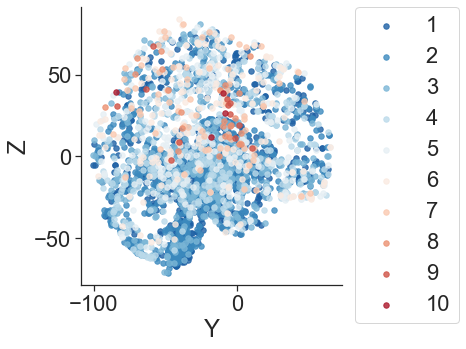

In [68]:
sns.lmplot(x='mni_nlin_y', y='mni_nlin_z', 
           hue = 'error_x_cat',legend=False, 
           data=preds_df, fit_reg=False, 
           scatter_kws={"s": 30},
          palette='RdBu_r')
plt.xlabel('Y')
plt.ylabel('Z')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_Xerror_YZ.pdf',
#            bbox_inches='tight')

In [72]:
ecol = 'error_y'
cut = pandas.cut(preds_df[ecol],10)
code = dict(zip(np.unique(cut),range(1,len(np.unique(cut))+1)))
code

{Interval(-0.0642, 6.58, closed='right'): 1,
 Interval(6.58, 13.159, closed='right'): 2,
 Interval(13.159, 19.738, closed='right'): 3,
 Interval(19.738, 26.316, closed='right'): 4,
 Interval(26.316, 32.895, closed='right'): 5,
 Interval(32.895, 39.474, closed='right'): 6,
 Interval(39.474, 46.052, closed='right'): 7,
 Interval(46.052, 52.631, closed='right'): 8,
 Interval(52.631, 59.21, closed='right'): 9,
 Interval(59.21, 65.788, closed='right'): 10}

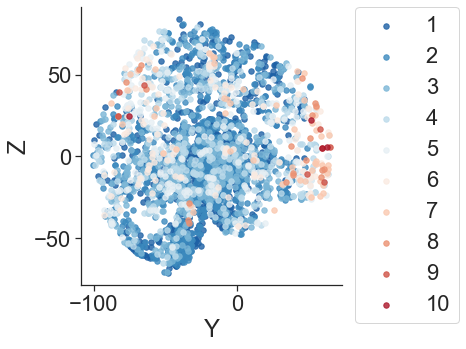

In [69]:
sns.lmplot(x='mni_nlin_y', y='mni_nlin_z', 
           hue = 'error_y_cat',legend=False, 
           data=preds_df, fit_reg=False, 
           scatter_kws={"s": 30},
          palette='RdBu_r')
plt.xlabel('Y')
plt.ylabel('Z')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_Yerror_YZ.pdf',
           bbox_inches='tight')

In [73]:
ecol = 'error_z'
cut = pandas.cut(preds_df[ecol],10)
code = dict(zip(np.unique(cut),range(1,len(np.unique(cut))+1)))
code

{Interval(-0.043, 5.177, closed='right'): 1,
 Interval(5.177, 10.346, closed='right'): 2,
 Interval(10.346, 15.515, closed='right'): 3,
 Interval(15.515, 20.684, closed='right'): 4,
 Interval(20.684, 25.853, closed='right'): 5,
 Interval(25.853, 31.021, closed='right'): 6,
 Interval(31.021, 36.19, closed='right'): 7,
 Interval(36.19, 41.359, closed='right'): 8,
 Interval(41.359, 46.528, closed='right'): 9,
 Interval(46.528, 51.696, closed='right'): 10}

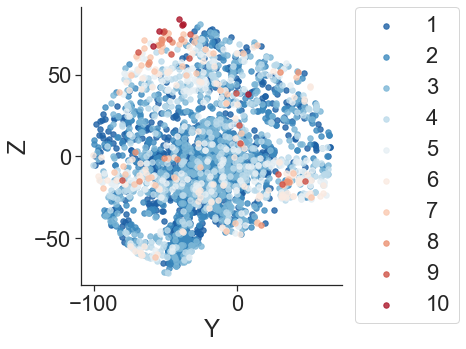

In [70]:
sns.lmplot(x='mni_nlin_y', y='mni_nlin_z', 
           hue = 'error_z_cat',legend=False, 
           data=preds_df, fit_reg=False, 
           scatter_kws={"s": 30},
          palette='RdBu_r')
plt.xlabel('Y')
plt.ylabel('Z')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_Zerror_YZ.pdf',
           bbox_inches='tight')

In [55]:
# is extremity or distance from center related to error?

# extremity
from scipy.spatial.distance import cdist
distmat = cdist(full_y.round(4).values,full_y.round(4).values)
dm = pandas.DataFrame(distmat)

preds_df.loc[:,'extremity'] = dm.mean(1).values

# distance from center
preds_df.loc[:,'abs_mni_nlin_y'] = preds_df.mni_nlin_y.abs().values
preds_df.loc[:,'abs_mni_nlin_z'] = preds_df.mni_nlin_z.abs().values
preds_df.loc[:,'center_dist'] = preds_df[['abs_mni_nlin_x','abs_mni_nlin_y',
                               'abs_mni_nlin_z']].mean(1).values

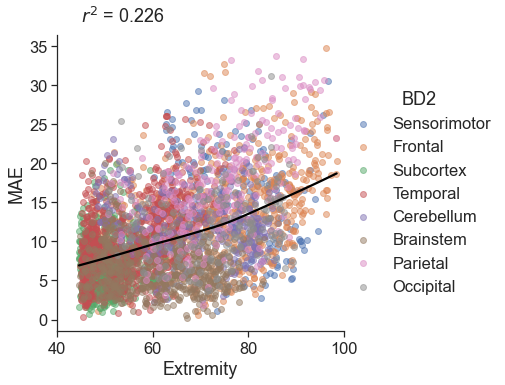

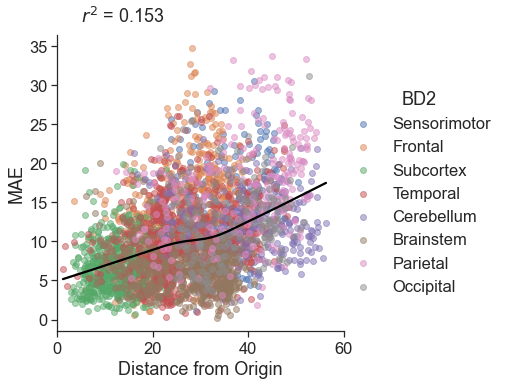

In [58]:
r2 = stats.pearsonr(preds_df.extremity,preds_df.total_error)[0]**2
sns.lmplot(x='extremity',y='total_error',data=preds_df,
          fit_reg=False,hue='BD2',scatter_kws={'alpha':0.5})
sns.regplot(x='extremity',y='total_error',data=preds_df,
          color='black',marker='',lowess=True)
plt.xlabel('Extremity')
plt.ylabel('MAE')
plt.xlim(40,100)
plt.text(45,38,'$r^{2}$ = %s'%round(r2,3))
# plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/ErrVExtremity.pdf',
#            bbox_inches='tight')
plt.show()

r2 = stats.pearsonr(preds_df.center_dist,preds_df.total_error)[0]**2
sns.lmplot(x='center_dist',y='total_error',data=preds_df, 
          fit_reg=False,hue='BD2',scatter_kws={'alpha':0.5})
sns.regplot(x='center_dist',y='total_error',data=preds_df,
         lowess=True,color='black',marker='')
plt.xlabel('Distance from Origin')
plt.ylabel('MAE')
plt.xlim(0,60)
plt.text(5,38,'$r^{2}$ = %s'%round(r2,3))
# plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/ErrVCenterDist.pdf',
#            bbox_inches='tight')
plt.show()

# sns.lmplot(x='abs_mni_nlin_x',y='error_x',data=preds_df, 
#           fit_reg=False,hue='BD2',scatter_kws={'alpha':0.5})
# sns.regplot(x='abs_mni_nlin_x',y='error_x',data=preds_df,
#           lowess=True,color='black',marker='')
# plt.show()

# sns.lmplot(x='abs_mni_nlin_y',y='error_y',data=preds_df, 
#           fit_reg=False,hue='BD2',scatter_kws={'alpha':0.5})
# sns.regplot(x='abs_mni_nlin_y',y='error_y',data=preds_df,
#           lowess=True,color='black',marker='')
# plt.show()

# sns.lmplot(x='abs_mni_nlin_z',y='error_z',data=preds_df, 
#           fit_reg=False,hue='BD2',scatter_kws={'alpha':0.5})
# sns.regplot(x='abs_mni_nlin_z',y='error_z',data=preds_df,
#           lowess=True,color='black',marker='')
# plt.show()

In [53]:
labs = [0 if gdf.loc[x,'slab_type'] == 'CX' else 1 if gdf.loc[x,'slab_type'] == 'BS' else 2 for x in gdf.index]
embedding = gdf[['abs_mni_nlin_x','mni_nlin_y','mni_nlin_z']].values

lmap = dict(zip(np.unique(labs),gdf.slab_type.unique()))
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab10(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=3,
                                                          color=color_str
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, filename='/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/brain.html')
    

'/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/brain.html'

In [54]:
labs = [0 if gdf.loc[x,'slab_type'] == 'CX' else 1 if gdf.loc[x,'slab_type'] == 'BS' else 2 for x in gdf.index]
embedding = preds_df[['predicted_x','predicted_y','predicted_z']].values

lmap = dict(zip(np.unique(labs),gdf.slab_type.unique()))
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab10(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=3,
                                                          color=color_str
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, filename='/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/corpredicted_brain.html')
    

'/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/corpredicted_brain.html'

# Examine components

In [108]:
#reload(XD)

In [38]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)
bsrx, bsry, allx_bs, ally_bs = XD.bootstrap_features(PLSRegression(n_components=3), 
                                                  pls_mod, 
                                                  pca_tfm, 
                                                  full_y, 
                                                  n_iterations=1000)

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


In [39]:
pls_mod = PLSRegression(n_components=3)
full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

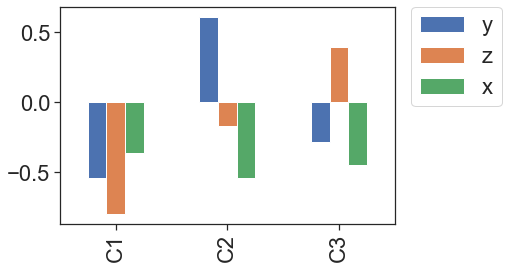

In [61]:
sns.set_context('notebook',font_scale=2)
g = pandas.DataFrame(pls_mod.y_weights_, 
                 index=['y','z','x'],
                 columns=['component %s'%x for x in range(3)]).T.plot.bar()
g.set_xticklabels(['C1','C2','C3'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/y_weights.pdf',
#             bbox_inches='tight')

In [40]:
plotr = pandas.concat([pandas.Series(allx_bs[0].values.flatten()),
                       #pandas.Series(list(range(100))*500)],
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, ''),
 Text(51, 0, ''),
 Text(52, 0, ''),
 Text(53, 0, ''),
 Text(54, 0, ''),
 Text(55, 0, ''),
 T

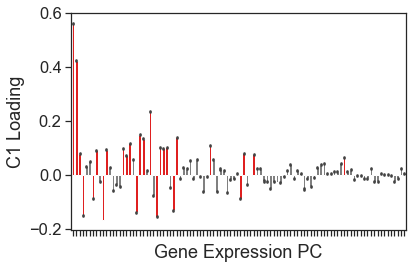

In [63]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]]
g=sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression PC')
plt.ylabel('C1 Loading')
g.set_xticklabels([None for x in range(100)])
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/C1_XWeights.pdf',
#             bbox_inches='tight')

In [41]:
sigs = multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,0] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]

In [42]:
newc1 = np.dot(pcamod.components_.T, new_loading)
newc1 = pandas.concat([pandas.Series(newc1), pandas.Series(bigdf.columns)],
                      axis=1)

In [43]:
probe_index = pandas.DataFrame(probes,copy=True)
probe_index.index = probe_index.gene_symbol.values
for i,row in newc1.iterrows():
    if row['gene_symbol'] in probe_index.index:
        nm = probe_index.loc[row['gene_symbol'],'gene_name']
        if type(nm) == pandas.core.series.Series:
            newc1.loc[i,'gene_name'] = nm.values[0]
        elif pandas.notnull(nm):
            newc1.loc[i,'gene_name'] = nm

In [67]:
newc1.sort_values(0,ascending=False)

0 gene_symbol                                          gene_name
600   0.083074         LXN                                            latexin
354   0.069295     SLC17A6  solute carrier family 17 (sodium-dependent ino...
750   0.061599        PAX8                                       paired box 8
806   0.061486        PRPH                                         peripherin
1394  0.061480     BHLHE22          basic helix-loop-helix family, member e22
...        ...         ...                                                ...
1101 -0.070036      WNT10A  wingless-type MMTV integration site family, me...
1055 -0.070199       NR2E1    nuclear receptor subfamily 2, group E, member 1
785  -0.081901       PRRX1                          paired related homeobox 1
1303 -0.083208       RXFP1     relaxin/insulin-like family peptide receptor 1
476  -0.094769       FOXG1                                                NaN

[1576 rows x 3 columns]

In [62]:
# newc1.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/GCORR_C1_genelist.csv')

In [44]:
allcomps = pandas.DataFrame(newc1,copy=True)
allcomps.columns = ['C1','gene_symbol','gene_name']

In [50]:
c1_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc1[0])

In [70]:
plotr = pandas.concat([pandas.Series(allx_bs[1].values.flatten()),
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, ''),
 Text(51, 0, ''),
 Text(52, 0, ''),
 Text(53, 0, ''),
 Text(54, 0, ''),
 Text(55, 0, ''),
 T

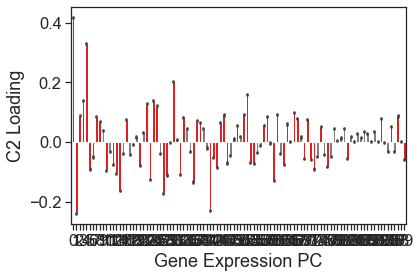

In [71]:
colors = ['Red' if x < 0.05 else 'Grey' for x in bsrx['p'].loc[1]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression PC')
plt.ylabel('C2 Loading')
g.set_xticklabels([None for x in range(100)])
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/C2_XWeights.pdf',
#             bbox_inches='tight')

In [86]:
# Need to modify this because for some reason nothing is significant


# sigs = multipletests(bsrx['p'].loc[1], method='fdr_bh')[0]
# new_loading = [pls_mod.x_loadings_[x,1] if not sigs[x] else 0 for x in range(pca_tfm.shape[-1])] # changed to if not here
# newc2 = np.dot(pcamod.components_.T, new_loading)
# newc2 = pandas.concat([pandas.Series(newc2), probes[['gene_symbol','gene_name']]], axis=1)

# UPDATE: The problem was the scores were sometimes arbitrarily inverted

In [45]:
sigs = multipletests(bsrx['p'].loc[1], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,1] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
newc2 = np.dot(pcamod.components_.T, new_loading)
newc2 = pandas.concat([pandas.Series(newc2), pandas.Series(bigdf.columns)],
                      axis=1)
for i,row in newc2.iterrows():
    if row['gene_symbol'] in probe_index.index:
        nm = probe_index.loc[row['gene_symbol'],'gene_name']
        if type(nm) == pandas.core.series.Series:
            newc2.loc[i,'gene_name'] = nm.values[0]
        elif pandas.notnull(nm):
            newc2.loc[i,'gene_name'] = nm

In [73]:
newc2.sort_values(0,ascending=False)

0 gene_symbol                                          gene_name
785   0.144329       PRRX1                          paired related homeobox 1
1345  0.100541       SYT10                                    synaptotagmin X
1543  0.084743       HSPB8                         heat shock 22kDa protein 8
1132  0.084002        ZIC1                                Zic family member 1
873   0.076650      SEMA3C  sema domain, immunoglobulin domain (Ig), short...
...        ...         ...                                                ...
976  -0.078757       FRAT2  frequently rearranged in advanced T-cell lymph...
847  -0.081482       MST1R  macrophage stimulating 1 receptor (c-met-relat...
600  -0.098023         LXN                                            latexin
233  -0.099984      COL5A1                          collagen, type V, alpha 1
639  -0.105009         MET  met proto-oncogene (hepatocyte growth factor r...

[1576 rows x 3 columns]

In [73]:
#newc2.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/GCorr_C2_genelist.csv')

In [46]:
allcomps.loc[:,'C2'] = newc2[newc2.columns[0]].values

In [48]:
c2_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc2[0])

In [49]:
gdf.loc[:,'C2_Expression'] = c2_xp

In [77]:
plotr = pandas.concat([pandas.Series(allx_bs[2].values.flatten()),
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']

<AxesSubplot:xlabel='Component', ylabel='Loading'>

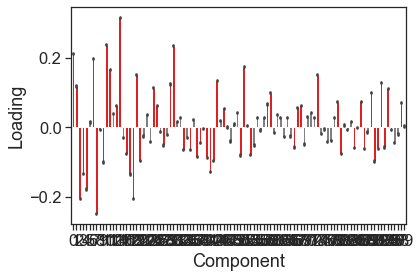

In [78]:
colors = ['Red' if x < 0.05 else 'Grey' for x in bsrx['p'].loc[2]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, ''),
 Text(51, 0, ''),
 Text(52, 0, ''),
 Text(53, 0, ''),
 Text(54, 0, ''),
 Text(55, 0, ''),
 T

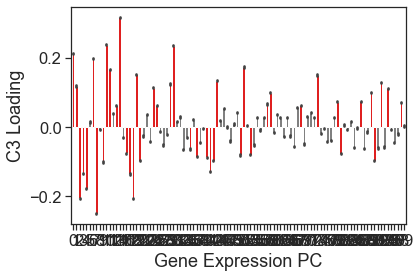

In [79]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[2], method='fdr_bh')[0]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression PC')
plt.ylabel('C3 Loading')
g.set_xticklabels([None for x in range(100)])
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/C3_XWeights.pdf',
#             bbox_inches='tight')

In [51]:
sigs = multipletests(bsrx['p'].loc[2], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,2] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
newc3 = np.dot(pcamod.components_.T, new_loading)
newc3 = pandas.concat([pandas.Series(newc3), pandas.Series(bigdf.columns)],
                      axis=1)
for i,row in newc3.iterrows():
    if row['gene_symbol'] in probe_index.index:
        nm = probe_index.loc[row['gene_symbol'],'gene_name']
        if type(nm) == pandas.core.series.Series:
            newc3.loc[i,'gene_name'] = nm.values[0]
        elif pandas.notnull(nm):
            newc3.loc[i,'gene_name'] = nm

In [81]:
newc3.sort_values(0,ascending=False)

0 gene_symbol                                          gene_name
1074  0.118543         TTR                                      transthyretin
792   0.096050      POU3F3                             POU class 3 homeobox 3
757   0.092169        PCP4                            Purkinje cell protein 4
720   0.079843        NRP1                                       neuropilin 1
1243  0.074363      ACVR1C                        activin A receptor, type IC
...        ...         ...                                                ...
1152 -0.070700     CYP26B1  cytochrome P450, family 26, subfamily B, polyp...
1262 -0.074173     TP53I11             tumor protein p53 inducible protein 11
774  -0.076514       PRKCD                            protein kinase C, delta
1076 -0.080677      TWIST1                       twist homolog 1 (Drosophila)
1126 -0.093659      ZNF436                            zinc finger protein 436

[1576 rows x 3 columns]

In [84]:
# newc3.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/GCorr_C3_genelist.csv')

In [52]:
allcomps.loc[:,'C3_Expression'] = newc3[newc3.columns[0]].values

In [53]:
c3_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc3[0])

In [54]:
gdf.loc[:,'C3_Expression'] = c3_xp

# Understanding the components

In [55]:
Medulla = ['arcuate nucleus of medulla, left','arcuate nucleus of medulla, right',
                 'central glial substance',
                 'central medullary reticular group, left','central medullary reticular group, right',
                 'cochlear nuclei, left','cochlear nuclei, right',
                 'cuneate nucleus, left','cuneate nucleus, right',
                 'dorsal motor nucleus of the vagus, left','dorsal motor nucleus of the vagus, right',
                 'gigantocellular group, left','gigantocellular group, right',
                 'gracile nucleus, left','gracile nucleus, right',
                 'hypoglossal nucleus, left','hypoglossal nucleus, right',
                 'inferior olivary complex, left','inferior olivary complex, right',
                 'lateral medullary reticular group, left','lateral medullary reticular group, right',
                 'raphe nuclei of medulla',
                 'spinal trigeminal nucleus, left','spinal trigeminal nucleus, right',
                 'superior olivary complex, left','superior olivary complex, right',
                 'vestibular nuclei, left','vestibular nuclei, right']

Pons =          ['abducens nucleus, left','abducens nucleus, right',
                 'central gray of the pons, left','central gray of the pons, right',
                 'facial motor nucleus, left','facial motor nucleus, right',
                 'lateral parabrachial nucleus, left','lateral parabrachial nucleus, right',
                 'locus ceruleus, left','locus ceruleus, right',
                 'medial parabrachial nucleus, left','medial parabrachial nucleus, right',
                 'medial parabrachial nucleus,right',
                 'motor nucleus of trigeminal nerve, left','motor nucleus of trigeminal nerve, right',
                 'nucleus subceruleus, left','nucleus subceruleus, right',
                 'pontine nuclei, left','pontine nuclei, right',
                 'pontine raphe nucleus','pontine raphe nucleus, left',
                 'pontine reticular formation, left','pontine reticular formation, right',
                 'principal sensory nucleus of trigeminal nerve, left','principal sensory nucleus of trigeminal nerve, right',
                 ]

DCN = ['dentate nucleus, left',
       'dentate nucleus, right',
       'emboliform nucleus, left',
       'emboliform nucleus, right',
       'fastigial nucleus, left',
       'fastigial nucleus, right',
       'globose nucleus, left',
       'globose nucleus, right']

Cerebellum = [x for x in gdf[gdf.slab_type=='CB']['structure_name'].unique().tolist() if x not in DCN]

Tectum = ['inferior colliculus, left',
          'superior colliculus, left','superior colliculus, right',
          'pretectal region']

Tegmentum = ['central gray substance of midbrain, left','central gray substance of midbrain, right',
            'cuneiform nucleus, left','cuneiform nucleus, right',
            'Edinger-Westphal nucleus, left','Edinger-Westphal nucleus, right',
            'interstitial nucleus of Cajal, left','interstitial nucleus of Cajal, right',
            'midbrain raphe nuclei','midbrain raphe nuclei, left',
            'midbrain reticular formation, left','midbrain reticular formation, right',
            'nucleus of Darkschewitsch, left',
            'oculomotor nuclear complex, right','oculomotor nuclear complex, left',
            'red nucleus, left','red nucleus, right',
            'subcuneiform nucleus, left','subcuneiform nucleus, right',
            'substantia nigra, pars compacta, left','substantia nigra, pars compacta, right',
            'substantia nigra, pars reticulata, left','substantia nigra, pars reticulata, right',
            'trochlear nucleus, left','trochlear nucleus, right',
            'ventral tegmental area, left','ventral tegmental area, right']

Hypothalamus = ['anterior hypothalamic area, left','anterior hypothalamic area, right',
               'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
               'dorsomedial hypothalamic nucleus, left',
               'lateral hypothalamic area, anterior region, left', 'lateral hypothalamic area, anterior region, right',
               'lateral hypothalamic area, mammillary region, left', 'lateral hypothalamic area, mammillary region, right',
               'lateral hypothalamic area, tuberal region, left',
               'paraventricular nucleus of the hypothalamus, left','paraventricular nucleus of the hypothalamus, right',
               'perifornical nucleus, left',
               'posterior hypothalamic area, left','posterior hypothalamic area, right',
               'preoptic region, left','preoptic region, right',
               'supraoptic nucleus, left','supraoptic nucleus, right',
               'ventromedial hypothalamic nucleus, left','ventromedial hypothalamic nucleus, right',]
                

Thalamus = ['anterior group of nuclei, left','anterior group of nuclei, right',
           'caudal group of intralaminar nuclei, left','caudal group of intralaminar nuclei, right',
           'dorsal lateral geniculate nucleus, left','dorsal lateral geniculate nucleus, right',
           'lateral group of nuclei, left, dorsal division','lateral group of nuclei, left, ventral division',
           'lateral group of nuclei, right, dorsal division','lateral group of nuclei, right, ventral division',
           'medial geniculate complex, left','medial geniculate complex, right',
           'medial group of nuclei, left','medial group of nuclei, right',
           'reticular nucleus of thalamus, left','reticular nucleus of thalamus, right',
           'rostral group of intralaminar nuclei, left','rostral group of intralaminar nuclei, right',
           'paraventricular nuclei, left of thalamus, left','paraventricular nuclei, right of thalamus, right',
           'posterior group of nuclei, left','posterior group of nuclei, right',
           'subthalamic nucleus, left','subthalamic nucleus, right',
           'zona incerta, left','zona incerta, right']

Other_Dien = ['lateral habenular nucleus, left','lateral habenular nucleus, right',
             'lateral mammillary nucleus, left',
             'lateral tuberal nucleus, left',
             'mammillary body, left','mammillary body, right',
             'medial habenular nucleus, left','medial habenular nucleus, right',
             'medial mammillary nucleus, left',
             'pallidohypothalamic nucleus, left',
             'pineal gland',
             'supramammillary nucleus, left',
             'tuberomammillary nucleus, left']

Limbic = ['CA1 field, left','CA1 field, right',
          'CA2 field, left','CA2 field, right',
          'CA3 field, left','CA3 field, right',
          'CA4 field, left','CA4 field, right',
          'amygdalohippocampal transition zone, left',
          'amygdalohippocampal transition zone, right',
          'basolateral nucleus, left','basolateral nucleus, right',
          'basomedial nucleus, left','basomedial nucleus, right',
          'central nucleus, left','central nucleus, right',
          'cortico-medial group, left','cortico-medial group, right',
          'dentate gyrus, left','dentate gyrus, right',
          'lateral nucleus, left','lateral nucleus, right',
          'septal nuclei, left','septal nuclei, right',
         'subiculum, left','subiculum, right']

Forebrain = ['basal nucleus of meynert, left','basal nucleus of meynert, right',
            'nucleus accumbens, left','nucleus accumbens, right',
            'nucleus of the diagonal band, left, horizontal division',
            'nucleus of the diagonal band, left, vertical division',
            'olfactory tubercle, left', 'piriform cortex, left',
            'substantia innominata, left','substantia innominata, right']

Striatum = ['bed  nucleus of stria terminalis, left',
            'body of caudate nucleus, left',
            'body of caudate nucleus, right',
            'globus pallidus, external segment, left','globus pallidus, external segment, right',
            'globus pallidus, internal segment, left','globus pallidus, internal segment, right',
            'head of caudate nucleus, left','head of caudate nucleus, right',
            'olfactory tubercle, left',
            'putamen, left','putamen, right',
           'tail of caudate nucleus, left','tail of caudate nucleus, right']

Anterior_Cingulate = ['cingulate gyrus, frontal part, left, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, left, superior bank of gyrus',
                     'cingulate gyrus, frontal part, right, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, right, superior bank of gyrus',
                     'paraterminal gyrus, right',
                     'parolfactory gyri, left','parolfactory gyri, right',
                     'subcallosal cingulate gyrus, left','subcallosal cingulate gyrus, right']

Posterior_Cingulate = ['cingulate gyrus, parietal part, left, inferior bank of gyrus',
                     'cingulate gyrus, parietal part, left, superior bank of gyrus',
                     'cingulate gyrus, parietal part, right, inferior bank of gyrus',
                     'cingulate gyrus, parietal part, right, superior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, left, inferior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, left, superior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, right, inferior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, right, superior bank of gyrus',]

Insula = ['claustrum, left','claustrum, right',
         'long insular gyri, left','long insular gyri, right',
         'short insular gyri, left','short insular gyri, right',]

Temporal = ["Heschl's gyrus, left", "Heschl's gyrus, right",
           'fusiform gyrus, left, bank of cos','fusiform gyrus, left, bank of the its',
           'fusiform gyrus, left, lateral bank of gyrus','fusiform gyrus, right, bank of cos',
           'fusiform gyrus, right, bank of the its','fusiform gyrus, right, lateral bank of gyrus',
           'inferior temporal gyrus, left, bank of mts','inferior temporal gyrus, left, bank of the its',
           'inferior temporal gyrus, left, lateral bank of gyrus','inferior temporal gyrus, right, bank of mts',
           'inferior temporal gyrus, right, bank of the its','inferior temporal gyrus, right, lateral bank of gyrus',
           'middle temporal gyrus, left, inferior bank of gyrus','middle temporal gyrus, left, superior bank of gyrus',
           'middle temporal gyrus, right, inferior bank of gyrus','middle temporal gyrus, right, superior bank of gyrus',
           'occipito-temporal gyrus, left, inferior bank of gyrus','occipito-temporal gyrus, left, superior bank of gyrus',
           'occipito-temporal gyrus, right, inferior bank of gyrus','occipito-temporal gyrus, right, superior bank of gyrus',
           'parahippocampal gyrus, left, bank of the cos','parahippocampal gyrus, left, lateral bank of gyrus',
           'parahippocampal gyrus, right, bank of the cos','parahippocampal gyrus, right, lateral bank of gyrus',
           'superior temporal gyrus, left, inferior bank of gyrus','superior temporal gyrus, left, lateral bank of gyrus',
           'superior temporal gyrus, right, inferior bank of gyrus','superior temporal gyrus, right, lateral bank of gyrus',
           'temporal pole, left, inferior aspect','temporal pole, left, medial aspect',
           'temporal pole, left, superior aspect','temporal pole, right, inferior aspect',
           'temporal pole, right, medial aspect','temporal pole, right, superior aspect',
           'transverse gyri, left','transverse gyri, right',
           'planum polare, left','planum polare, right',
           'planum temporale, left','planum temporale, right']

Parietal = ['angular gyrus, left, inferior bank of gyrus','angular gyrus, left, superior bank of gyrus',
            'angular gyrus, right, inferior bank of gyrus','angular gyrus, right, superior bank of gyrus',
            'precuneus, left, inferior lateral bank of gyrus','precuneus, left, superior lateral bank of gyrus',
            'precuneus, right, inferior lateral bank of gyrus','precuneus, right, superior lateral bank of gyrus',
            'superior parietal lobule, left, inferior bank of gyrus','superior parietal lobule, left, superior bank of gyrus',
            'superior parietal lobule, right, inferior bank of gyrus','superior parietal lobule, right, superior bank of gyrus',
            'supramarginal gyrus, left, inferior bank of gyrus','supramarginal gyrus, left, superior bank of gyrus',
            'supramarginal gyrus, right, inferior bank of gyrus','supramarginal gyrus, right, superior bank of gyrus']

Frontal = ['anterior orbital gyrus, left','anterior orbital gyrus, right',
           'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
          'frontal operculum, left','frontal operculum, right',
          'frontal pole, left, inferior aspect','frontal pole, left, medial aspect',
          'frontal pole, left, superior aspect','frontal pole, right, inferior aspect',
          'frontal pole, right, medial aspect','frontal pole, right, superior aspect',
          'gyrus rectus, left','gyrus rectus, right',
          'inferior frontal gyrus, opercular part, left','inferior frontal gyrus, opercular part, right',
          'inferior frontal gyrus, orbital part, left','inferior frontal gyrus, orbital part, right',
          'inferior frontal gyrus, triangular part, left','inferior frontal gyrus, triangular part, right',
          'inferior rostral gyrus, left','inferior rostral gyrus, right',
          'lateral orbital gyrus, left','lateral orbital gyrus, right',
          'medial orbital gyrus, left','medial orbital gyrus, right',
          'middle frontal gyrus, left, inferior bank of gyrus','middle frontal gyrus, left, superior bank of gyrus',
          'middle frontal gyrus, right, inferior bank of gyrus','middle frontal gyrus, right, superior bank of gyrus',
          'posterior orbital gyrus, left','posterior orbital gyrus, right',
          'superior frontal gyrus, left','superior frontal gyrus, left, lateral bank of gyrus',
          'superior frontal gyrus, left, medial bank of gyrus','superior frontal gyrus, right, lateral bank of gyrus',
          'superior frontal gyrus, right, medial bank of gyrus',
          'superior rostral gyrus, left','superior rostral gyrus, right']

Occipital = ['cuneus, left, peristriate',
             'cuneus, left, striate',
             'cuneus, right, peristriate',
             'cuneus, right, striate',
             'inferior occipital gyrus, left, inferior bank of gyrus','inferior occipital gyrus, left, superior bank of gyrus',
             'inferior occipital gyrus, right, inferior bank of gyrus','inferior occipital gyrus, right, superior bank of gyrus',
             'lingual gyrus, left, peristriate','lingual gyrus, left, striate',
             'lingual gyrus, right, peristriate','lingual gyrus, right, striate',
             'occipital pole, left, inferior aspect',
             'occipital pole, left, lateral aspect','occipital pole, left, superior aspect',
             'superior occipital gyrus, left, inferior bank of gyrus','superior occipital gyrus, left, superior bank of gyrus',
             'superior occipital gyrus, right, inferior bank of gyrus','superior occipital gyrus, right, superior bank of gyrus',]

Sensorimotor = ['paracentral lobule, anterior part, left','paracentral lobule, anterior part, left, inferior bank of gyrus',
                'paracentral lobule, anterior part, left, superior bank of gyrus','paracentral lobule, anterior part, right, inferior bank of gyrus',
                'paracentral lobule, anterior part, right, superior bank of gyrus','paracentral lobule, posterior part, left, bank of cingulate sulcus',
                'paracentral lobule, posterior part, left, lateral bank of gyrus','paracentral lobule, posterior part, right, bank of cingulate sulcus',
                'paracentral lobule, posterior part, right, lateral bank of gyrus',
                'postcentral gyrus, left, bank of the central sulcus','postcentral gyrus, left, bank of the posterior central sulcus',
                'postcentral gyrus, left, inferior lateral aspect of gyrus','postcentral gyrus, left, superior lateral aspect of gyrus',
                'postcentral gyrus, right, bank of the central sulcus','postcentral gyrus, right, bank of the posterior central sulcus',
                'postcentral gyrus, right, inferior lateral aspect of gyrus','postcentral gyrus, right, superior lateral aspect of gyrus',
                'precentral gyrus, left, bank of the central sulcus','precentral gyrus, left, bank of the precentral sulcus',
                'precentral gyrus, left, inferior lateral aspect of gyrus','precentral gyrus, left, superior lateral aspect of gyrus',
                'precentral gyrus, right, bank of the central sulcus','precentral gyrus, right, bank of the precentral sulcus',
                'precentral gyrus, right, inferior lateral aspect of gyrus','precentral gyrus, right, superior lateral aspect of gyrus']
            
divs = [Medulla, Pons, DCN, Cerebellum, Tectum, Tegmentum, Hypothalamus, Thalamus, Other_Dien,
                  Limbic, Forebrain, Striatum, Anterior_Cingulate, Posterior_Cingulate, Insula,
                  Temporal, Frontal, Parietal, Occipital, Sensorimotor]
names = ['Medulla', 'Pons', 'DCN', 'Cerebellum', 'Tectum', 'Tegmentum', 'Hypothalamus', 'Thalamus', 
         'Other_Dien', 'Limbic', 'Forebrain', 'Striatum', 'Anterior_Cingulate', 'Posterior_Cingulate', 
         'Insula', 'Temporal', 'Frontal', 'Parietal', 'Occipital', 'Sensorimotor']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'brain_divison'] = name
    

In [86]:
# For C1
Meyelencephalon = Medulla[:] 
Metencelphalon = Pons + DCN + Cerebellum
Mesencephalon = Tectum + Tegmentum
Diencephalon = Hypothalamus + Thalamus + Other_Dien
Telencephalon = Limbic + Forebrain + Striatum + Anterior_Cingulate + Posterior_Cingulate +\
                Insula + Temporal + Frontal + Parietal + Occipital + Sensorimotor

divs = [Meyelencephalon, Metencelphalon, Mesencephalon, Diencephalon, Telencephalon]
names = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 'Diencephalon', 'Telencephalon']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'Neural_Tube_segment'] = name
    

In [87]:
# For C3

Auditory = ["Heschl's gyrus, left", "Heschl's gyrus, right",
            'planum polare, left','planum polare, right',
            'planum temporale, left','planum temporale, right',
            'transverse gyri, left','transverse gyri, right']
Visual = ['cuneus, left, peristriate','cuneus, left, striate',
                 'cuneus, right, peristriate','cuneus, right, striate',
                 'lingual gyrus, left, peristriate','lingual gyrus, left, striate',
                 'lingual gyrus, right, peristriate','lingual gyrus, right, striate']
Olfactory = ['olfactory tubercle, left', 'piriform cortex, left']


Sensory_Cortex = Sensorimotor + Auditory + Visual + Olfactory
gdf.loc[gdf[gdf.structure_name.isin(Sensory_Cortex)].index,'Cortical_Type'] = 'Sensory'

Association_Cortex = [x for x in Telencephalon if x not in Striatum and x not in Sensory_Cortex]
gdf.loc[gdf[gdf.structure_name.isin(Association_Cortex)].index,'Cortical_Type'] = 'Association_Cortex'

Cerebellar_Cortex = [x for x in Cerebellum]
gdf.loc[gdf[gdf.structure_name.isin(Cerebellar_Cortex)].index,'Cortical_Type'] = 'Cerebellar_Cortex'

Not_Cortex = Meyelencephalon + Mesencephalon + Pons + DCN + Diencephalon + Striatum
gdf.loc[gdf[gdf.structure_name.isin(Not_Cortex)].index,'Cortical_Type'] = 'Not Cortex'


divs = [Auditory, Visual, Olfactory, Sensorimotor, Association_Cortex, Not_Cortex, Cerebellar_Cortex]
names = ['Auditory','Visual','Olfactory','Sensorimotor','Association_Cortex','Not_Cortex','Cerebellar_Cortex']
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'Sensory_Type'] = name


In [88]:
# for c2
alar_medulla = ['spinal trigeminal nucleus, right', 'spinal trigeminal nucleus, left',
               'cochlear nuclei, left','cochlear nuclei, right',
               'vestibular nuclei, left','vestibular nuclei, right',
               'inferior olivary complex, left','inferior olivary complex, right',
                'gracile nucleus, left','gracile nucleus, right',
               'cuneate nucleus, left','cuneate nucleus, right',
               'superior olivary complex, left','superior olivary complex, right',]

basal_medulla = ['hypoglossal nucleus, left','hypoglossal nucleus, right',
                'lateral medullary reticular group, left','lateral medullary reticular group, right',
                'dorsal motor nucleus of the vagus, left','dorsal motor nucleus of the vagus, right', 
                'arcuate nucleus of medulla, left','arcuate nucleus of medulla, right',
                'central medullary reticular group, left','central medullary reticular group, right',
                'raphe nuclei of medulla',
                'gigantocellular group, left','gigantocellular group, right', ]


divs = [alar_medulla, basal_medulla]
names = ['Alar_Medulla','Basal_Medulla']
med_division = dict(zip(names,divs))

for name, div in med_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'brain_divison'] = name

dorsal_plate = ['Cerebellum', 'Thalamus', 'Tectum', 'Alar_Medulla']
ventral_plate = ['Hypothalamus','Pons','Tegmentum','Basal_Medulla']
subcortical = ['Forebrain', 'Striatum', 'Limbic']
frontal = ['Anterior_Cingulate','Insula','Frintal']
temporal = ['Temporal']
somatomotor = ['Sensorimotor']
parietal = ['Parietal']
occipital = ['Occipital']

gdf.loc[gdf[gdf.brain_divison.isin(dorsal_plate)].index,'Neural_Plate'] = 'Dorsal'
gdf.loc[gdf[gdf.brain_divison.isin(ventral_plate)].index,'Neural_Plate'] = 'Ventral'
gdf.loc[gdf[gdf.brain_divison.isin(subcortical)].index,'Neural_Plate'] = 'Subcortical'
gdf.loc[gdf[gdf.brain_divison.isin(frontal)].index,'Neural_Plate'] = 'Frontal'
gdf.loc[gdf[gdf.brain_divison.isin(temporal)].index,'Neural_Plate'] = 'Temporal'
gdf.loc[gdf[gdf.brain_divison.isin(somatomotor)].index,'Neural_Plate'] = 'Somatomotor'
gdf.loc[gdf[gdf.brain_divison.isin(parietal)].index,'Neural_Plate'] = 'Parietal'
gdf.loc[gdf[gdf.brain_divison.isin(occipital)].index,'Neural_Plate'] = 'Occipital'


In [302]:
#gdf.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_gcx_wholebrain_info_W_BRAIN_DIVISIONS.csv')

In [89]:
# for GTeX

gfrontal = Frontal
gAC = Anterior_Cingulate
gCereb = Cerebellum
gHT = Hypothalamus
gCaud = ['body of caudate nucleus, left',
         'body of caudate nucleus, right',
        'head of caudate nucleus, left',
         'head of caudate nucleus, right',
        'tail of caudate nucleus, left',
         'tail of caudate nucleus, right']
gPut = ['putamen, left','putamen, right',]
gGP = ['globus pallidus, external segment, left',
       'globus pallidus, external segment, right',
       'globus pallidus, internal segment, left',
       'globus pallidus, internal segment, right',]
gAmyg = ['basolateral nucleus, left','basolateral nucleus, right',
          'basomedial nucleus, left','basomedial nucleus, right',
          'central nucleus, left','central nucleus, right',
          'cortico-medial group, left','cortico-medial group, right',
        'lateral nucleus, left','lateral nucleus, right']
gHipp = ['CA1 field, left','CA1 field, right',
          'CA2 field, left','CA2 field, right',
          'CA3 field, left','CA3 field, right',
          'CA4 field, left','CA4 field, right',
         'dentate gyrus, left','dentate gyrus, right',
        'subiculum, left','subiculum, right']
sn = ['substantia nigra, pars compacta, left',
      'substantia nigra, pars compacta, right',
      'substantia nigra, pars reticulata, left',
      'substantia nigra, pars reticulata, right']
gNAcc = ['nucleus accumbens, left','nucleus accumbens, right',]

divs = [gfrontal, gAC, gCereb, gHT, gCaud, gPut, gGP, gAmyg, 
        gHipp,sn,gNAcc]
names = ['Frontal', 'AntCing', 'Cerebellum', 'Hypothalamus', 
         'Caudate','Putamen','Pallidum','Amygdala','Hippocampus',
        'Nigra','Accumbens']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'GTeX_div'] = name
    

In [90]:
gdf.loc[:,'Component1_Expresion'] = c1_xp
gdf.loc[:,'Component2_Expresion'] = c2_xp
gdf.loc[:,'Component3_Expresion'] = c3_xp


/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 47.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 52.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Component 1 Expression')

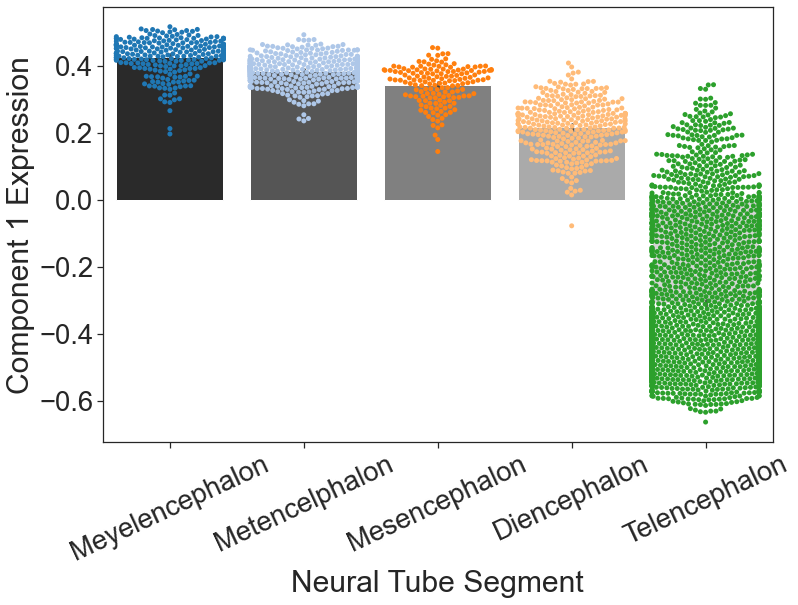

In [91]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 
         'Diencephalon', 'Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='Component1_Expresion', 
            data=gdf,palette='gray',
           order = order)
g=sns.swarmplot(x='Neural_Tube_segment', y='Component1_Expresion', 
              data=gdf, 
              #hue='brain_divison',
              order = order, palette='tab20')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(order,rotation=25)
plt.xlabel('Neural Tube Segment')
plt.ylabel('Component 1 Expression')
# plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/C1_NT.pdf',
#            bbox_inches='tight')

In [92]:
rbpal = [sns.color_palette('RdBu')[0],
                      sns.color_palette('RdBu')[-1]]

/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 19.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, '')

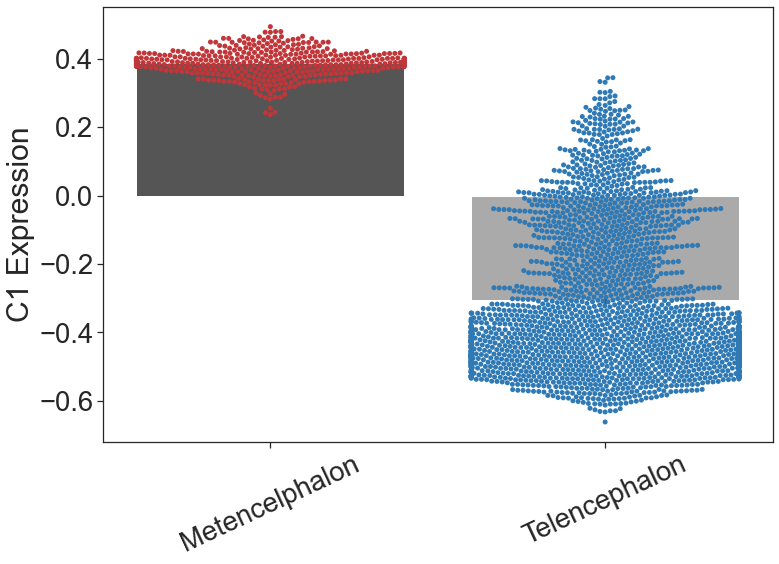

In [93]:
# Just cortex and cerebellum
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Metencelphalon','Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='Component1_Expresion', 
            data=gdf[gdf.Neural_Tube_segment.isin(order)],
            palette='gray',
           order = order
           )
g=sns.swarmplot(x='Neural_Tube_segment', y='Component1_Expresion', 
              data=gdf[gdf.Neural_Tube_segment.isin(order)], 
              #hue='brain_divison',
              order = order, palette=rbpal)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(order,rotation=25)
plt.ylabel('C1 Expression')
plt.xlabel('')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/BSComp_ABA_C1.pdf',
#            bbox_inches='tight')

In [94]:
bsn = []
for x in gdf.structure_name.values:
    if ',' in x:
        bsn.append(x.split(',')[0])
    else:
        bsn.append(x)
gdf.loc[:,'bilateral_structure_name'] = bsn

In [105]:
gdf.Sensory_Type.value_counts()

Association_Cortex    1729
Not_Cortex            1089
Cerebellar_Cortex      256
Sensorimotor           215
Visual                 107
Auditory                60
Olfactory                8
Name: Sensory_Type, dtype: int64

/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 38.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Component 1 Expression')

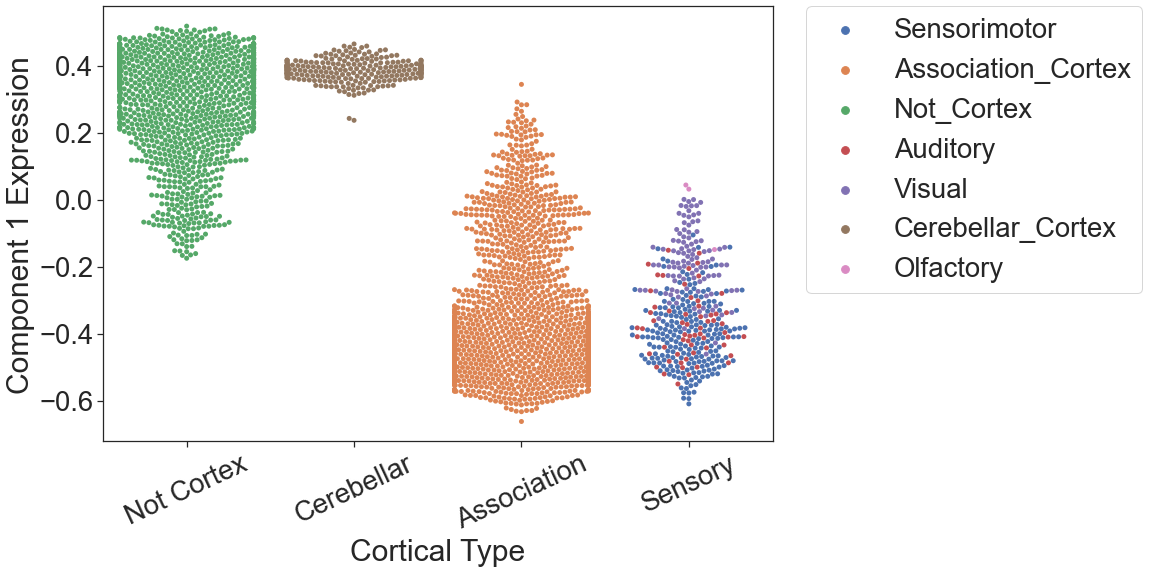

In [96]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Cerebellar_Cortex','Association_Cortex','Sensory']
g=sns.swarmplot(x='Cortical_Type', y='Component1_Expresion', data=gdf, hue='Sensory_Type', order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Not Cortex','Cerebellar','Association','Sensory'],
                  rotation=25)
plt.xlabel('Cortical Type')
plt.ylabel('Component 1 Expression')
# plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/C1_Modals.pdf',
#            bbox_inches='tight')

/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 42.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0, 'Meyelencephalon'),
 Text(1, 0, 'Metencelphalon'),
 Text(2, 0, 'Mesencephalon'),
 Text(3, 0, 'Diencephalon')]

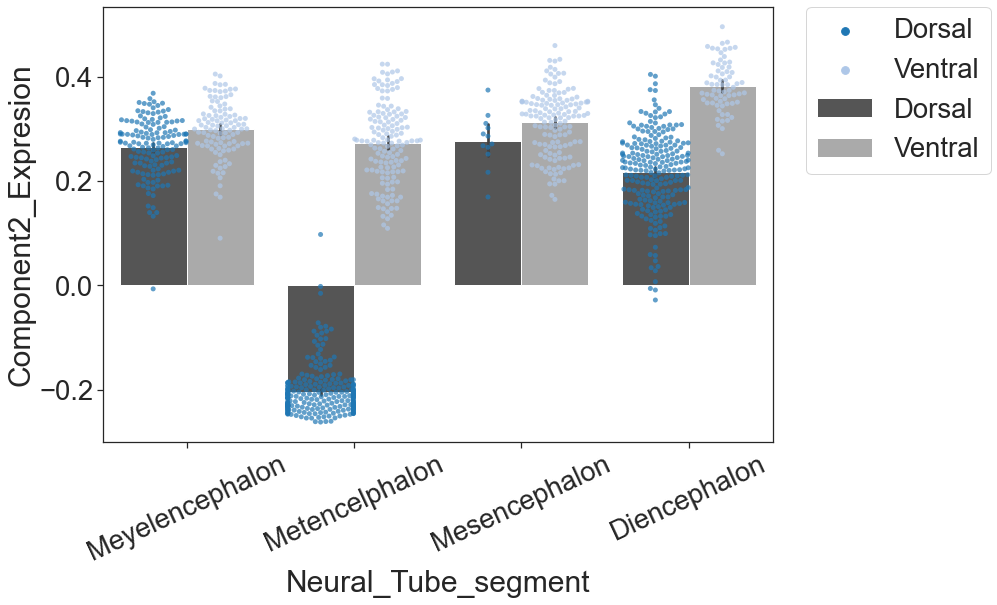

In [97]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 
         'Diencephalon']
horder = ['Dorsal','Ventral']
sns.barplot(x='Neural_Tube_segment', y='Component2_Expresion', 
            data=gdf[gdf.Neural_Tube_segment!='Telencephalon'],
            palette='gray',hue='Neural_Plate',
           order = order,hue_order=horder)
g=sns.swarmplot(x='Neural_Tube_segment', y='Component2_Expresion', 
              data=gdf[gdf.Neural_Tube_segment!='Telencephalon'],
                hue='Neural_Plate',dodge=True,
              order = order, palette='tab20',hue_order=horder,
               alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(order,rotation=25)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/C2_NT-NoTele.pdf',
#            bbox_inches='tight')

/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'Telencephalon')

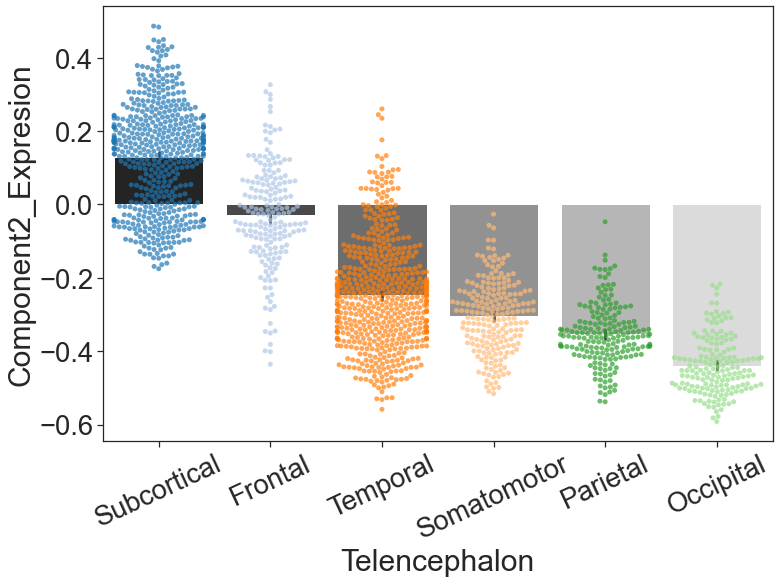

In [98]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Subcortical', 'Frontal', 'Temporal','Somatomotor', 
         'Parietal','Occipital']
#horder = ['Dorsal','Ventral']
sns.barplot(x='Neural_Plate', y='Component2_Expresion', 
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
            palette='gray',#hue='Neural_Plate',
           order = order,
            hue_order=order
           )
g=sns.swarmplot(x='Neural_Plate', y='Component2_Expresion', 
              data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
                #hue='Neural_Plate',dodge=True,
              order = order, 
                #hue_order=order,
                palette='tab20',alpha=0.7)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(order,rotation=25)
plt.xlabel('Telencephalon')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/C2_NT-TeleOnly.pdf',
#            bbox_inches='tight')

In [119]:
# for i in range(1,4):
#     c_vals = pandas.pivot_table(gdf,values='Component%s_Expresion'%i,
#                                  index='brain_divison',aggfunc=np.mean
#                                 )
#     for div in c_vals.index:
#         sem = gdf[gdf.brain_divison==div]['Component%s_Expresion'%i
#                                          ].sem()
#         c_vals.loc[div,'sem'] = sem
#     c_vals.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/GCorr_BSComp_ABA_C%s_data.csv'%i)
#     c_vals.head()

In [120]:
# c2_vals = pandas.pivot_table(gdf,values='Component2_Expresion',
#                              index='brain_divison',aggfunc=np.mean
#                             )
# for div in c2_vals.index:
#     sem = gdf[gdf.brain_divison==div]['Component2_Expresion'].sem()
#     c2_vals.loc[div,'sem'] = sem
# c2_vals.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/GCorr_BSComp_ABA_C2_data.csv')
# c2_vals.head()

Component2_Expresion       sem
brain_divison                                     
Alar_Medulla                    0.240741  0.004108
Anterior_Cingulate              0.035712  0.013029
Basal_Medulla                   0.270035  0.005305
Cerebellum                     -0.241571  0.002791
DCN                             0.215401  0.009181

In [49]:
# ### same thing for GTeX
# for i in range(1,4):
#     c_vals = pandas.pivot_table(gdf,values='Component%s_Expresion'%i,
#                                  index='GTeX_div',aggfunc=np.mean
#                                 )
#     for div in c_vals.index:
#         sem = gdf[gdf.GTeX_div==div]['Component%s_Expresion'%i
#                                          ].sem()
#         c_vals.loc[div,'sem'] = sem
#     c_vals.to_csv('~/Science/PLS_GXP/GCorr_GTexComp_ABA_C%s_data.csv'%i)


/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 42.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 26.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 28.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Component 2 Expression')

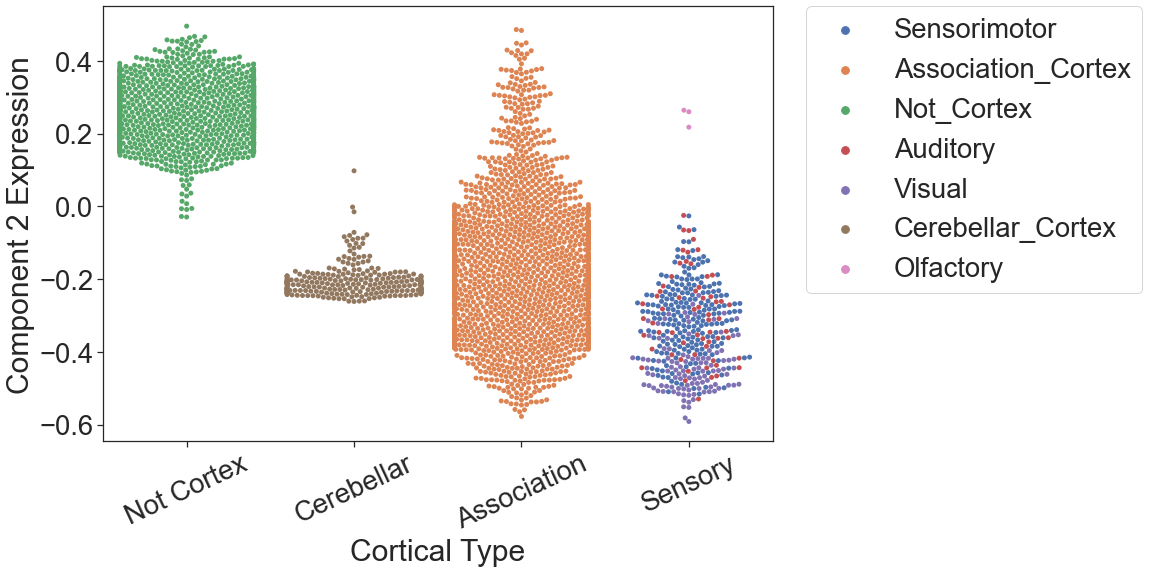

In [99]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Cerebellar_Cortex','Association_Cortex','Sensory']
g=sns.swarmplot(x='Cortical_Type', y='Component2_Expresion', data=gdf, hue='Sensory_Type', order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Not Cortex','Cerebellar','Association','Sensory'],
                  rotation=25)
plt.xlabel('Cortical Type')
plt.ylabel('Component 2 Expression')
# plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/C2_Modals.pdf',
#            bbox_inches='tight')

/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 41.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 36.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jacobv/jakepy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 32.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Component 3 Expression')

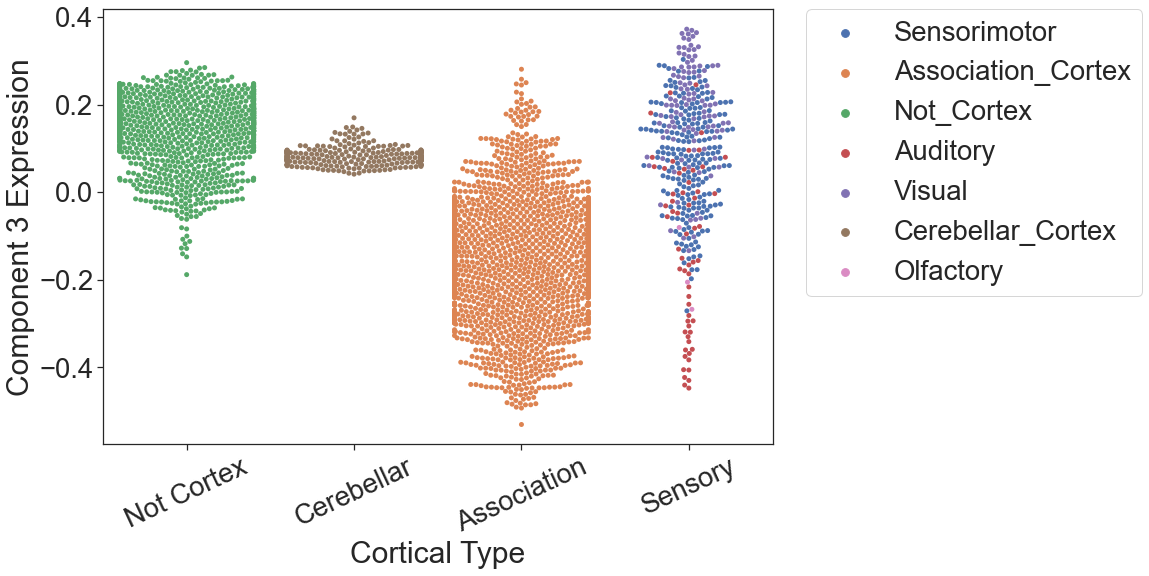

In [100]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Cerebellar_Cortex','Association_Cortex','Sensory']
g = sns.swarmplot(x='Cortical_Type', y='Component3_Expresion', 
              data=gdf, hue='Sensory_Type',order=order,
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Not Cortex','Cerebellar','Association','Sensory'],
                  rotation=25)
plt.xlabel('Cortical Type')
plt.ylabel('Component 3 Expression')
# plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/C3_Modals.pdf',
#            bbox_inches='tight')

# Projection

In [56]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf))
pls_mod = PLSRegression(n_components=3)
#full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

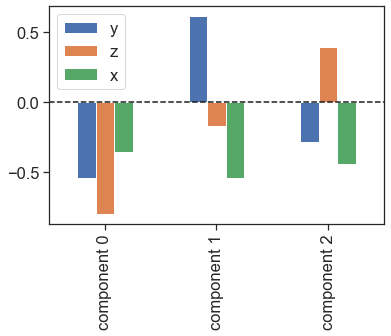

In [103]:
sns.set_context('notebook',font_scale=1.5)
pandas.DataFrame(pls_mod.y_weights_, 
                 index=['y','z','x'],
                 columns=['component %s'%x for x in range(3)]).T.plot.bar()
plt.axhline(0,c='k',ls='--')
# plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/y_weights.pdf',
#            bbox_inches='tight')

In [ ]:
#gcx_img.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/C2_XWeights.nii.gz')

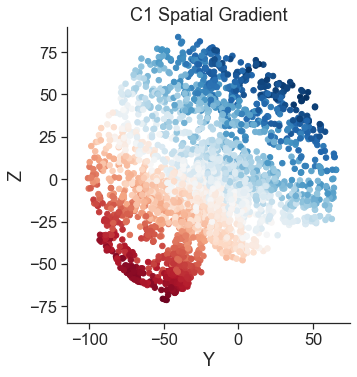

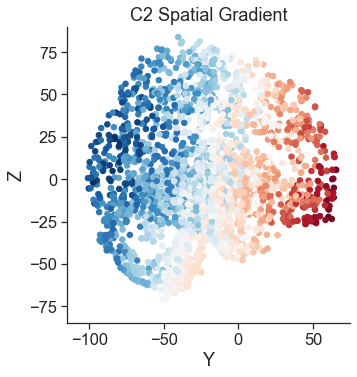

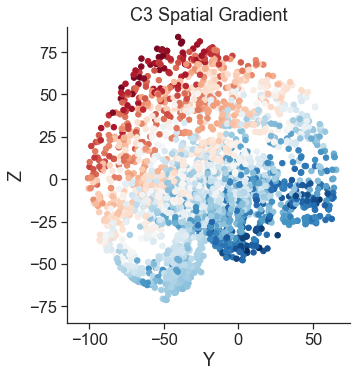

In [104]:
from sklearn.preprocessing import MinMaxScaler

cmap = sns.color_palette('RdBu_r',as_cmap=True)

for i in range(pls_mod.y_weights_.shape[0]):
    #sg = np.dot(full_y.values,pls_mod.y_weights_[i,:])
    sg = np.dot(full_y.values,pls_mod.y_weights_[:,i])
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    gdf.loc[:,'C%s_SmoothGradient'%(i+1)] = sg
    norm = matplotlib.colors.Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Spatial Gradient'%(i+1))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_SpatialC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')

#     if i == 0:
#     # colorbar
#         a = np.array([[0,1]])
#         #a = np.linspace(0,1,10)
#         plt.figure(figsize=(.2, 5))
#         img = plt.imshow(a, cmap="RdBu_r")
#         plt.gca().set_visible(False)
#         cax = plt.axes([0.1, 0.2, 0.8, 0.6])
#         cbar = plt.colorbar(orientation="vertical", cax=cax)
#         #newticks = [int(round(norm.inverse(x))) for x in cbar.get_ticks()]
#         newticks = [norm.inverse(x) for x in cbar.get_ticks()]
#         cbar.set_ticks(cbar.get_ticks())
#         cbar.set_ticklabels(newticks)
#         plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_component_cbar.pdf',
#                    bbox_inches='tight')

#         plt.show()




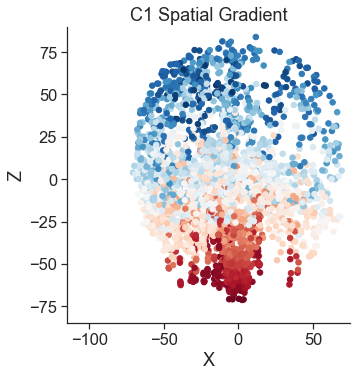

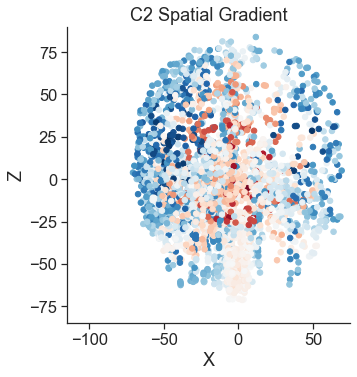

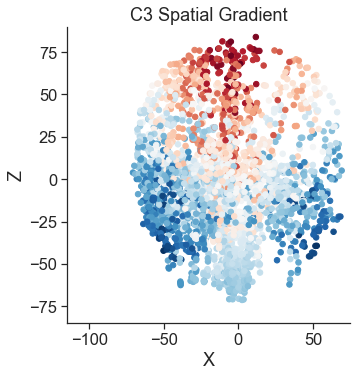

In [105]:
from sklearn.preprocessing import MinMaxScaler

cmap = sns.color_palette('RdBu_r',as_cmap=True)

for i in range(pls_mod.y_weights_.shape[0]):
    sg = np.dot(full_y.values,pls_mod.y_weights_[:,i])
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    gdf.loc[:,'C%s_SmoothGradient'%(i+1)] = sg
    norm = matplotlib.colors.Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.title('C%s Spatial Gradient'%(i+1))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_SpatialC%s_XZ.pdf'%(i+1),
#                bbox_inches='tight')





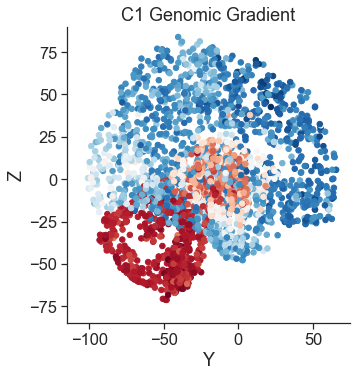

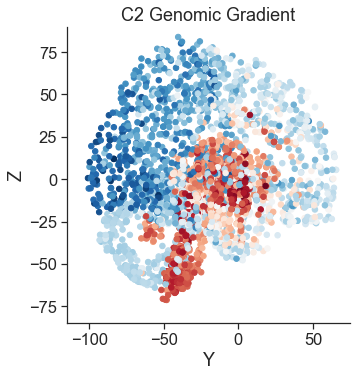

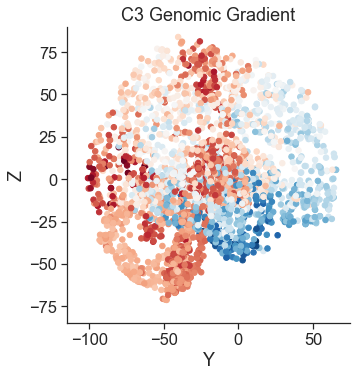

In [106]:
from sklearn.preprocessing import MinMaxScaler

cmap = sns.color_palette('RdBu_r',as_cmap=True)

for i in range(pls_mod.y_weights_.shape[0]):
    #if i == 2:
    sg = gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    #else:
    #    sg = -gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = matplotlib.colors.Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Genomic Gradient'%(i+1))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_GenomicC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')



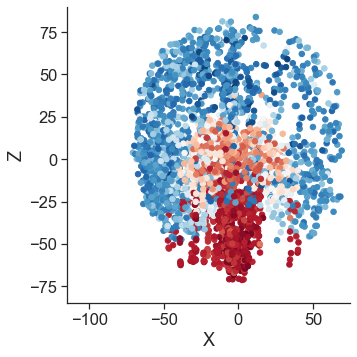

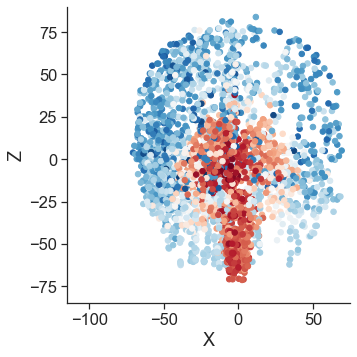

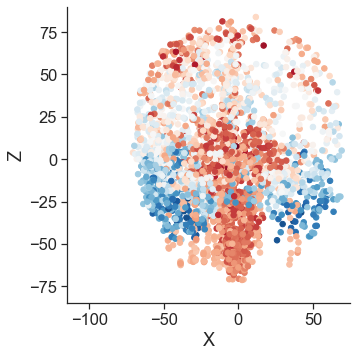

In [107]:
from sklearn.preprocessing import MinMaxScaler

cmap = sns.color_palette('RdBu_r',as_cmap=True)

for i in range(pls_mod.y_weights_.shape[0]):
    sg = gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = matplotlib.colors.Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('X')
    plt.ylabel('Z')
#    plt.title('C%s Genomic Gradient'%(i+1))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_GenomicC%s_XZ.pdf'%(i+1),
#                bbox_inches='tight')



In [108]:
code = dict(zip(range(1,11),
               [1,1,1,2,2,2,2,3,3,3]))
conversion = []
for i,row in gdf.iterrows():
    conversion.append('%s%s%s'%(code[row['C1_SpatialGradient']],
                          code[row['C2_SpatialGradient']],
                          code[row['C3_SpatialGradient']]))
code = dict(zip(np.unique(conversion),
               range(1,len(np.unique(conversion))+1)))
gdf.loc[:,'GradExp_Gp'] = [code[x] for x in conversion]

KeyError: 'C1_SpatialGradient'

In [138]:
code

{'111': 1,
 '112': 2,
 '121': 3,
 '122': 4,
 '123': 5,
 '132': 6,
 '133': 7,
 '211': 8,
 '212': 9,
 '221': 10,
 '222': 11,
 '223': 12,
 '231': 13,
 '232': 14,
 '233': 15,
 '311': 16,
 '321': 17,
 '322': 18,
 '331': 19,
 '332': 20,
 '333': 21}

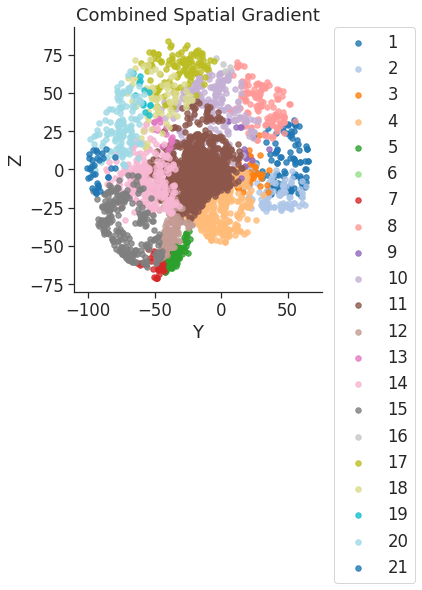

In [139]:
sns.set_context('notebook',font_scale=1.5)
sns.lmplot('mni_nlin_y', 'mni_nlin_z', 
               hue = 'GradExp_Gp',legend=False, 
               data=gdf, fit_reg=False, 
               scatter_kws={"s": 30},
              palette='tab20')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Combined Spatial Gradient')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

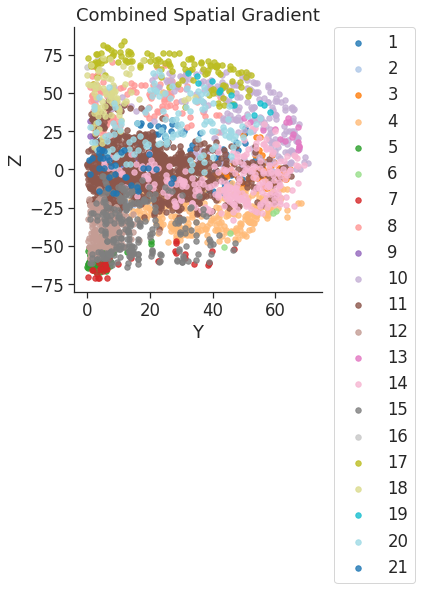

In [163]:
sns.lmplot('abs_mni_nlin_x', 'mni_nlin_z', 
               hue = 'GradExp_Gp',legend=False, 
               data=gdf, fit_reg=False, 
               scatter_kws={"s": 30},
              palette='tab20')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Combined Spatial Gradient')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Export for mouse reanalysis

In [111]:
all_comps = allcomps[['gene_symbol','gene_name','C1','C2','C3_Expression']]
all_comps.columns = ['gene_symbol','gene_name','C1','C2','C3']
all_comps.to_csv('/Users/jacobv/Science/PLS_GXP/Mouse/HumanComps_mouseGenes.csv')

# Mouse Component Expression in Humans!

In [112]:
bigdf.shape

(3466, 1576)

In [113]:
allcomps.shape

(1576, 5)

In [121]:
bigdf.columns.tolist() == homo.index.tolist()

True

In [123]:
np.dot(homo.MouseC1,bigdf.T).shape

(3466,)

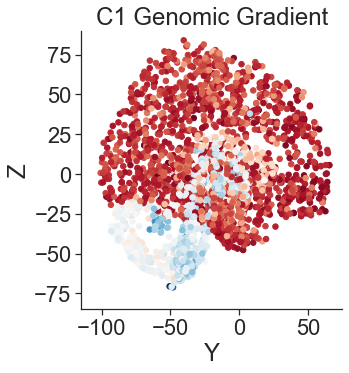

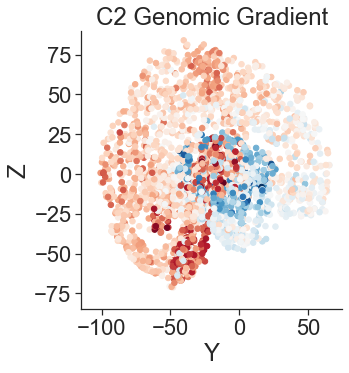

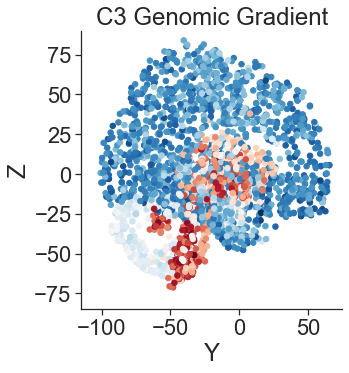

In [59]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import Normalize

cmap = sns.color_palette('RdBu_r',as_cmap=True)

for i in range(1,4):
    #if i == 2:
    sg = np.dot(homo['MouseC%s'%i],bigdf.T)
    #else:
    #    sg = -gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Genomic Gradient'%(i))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_GenomicC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')



In [127]:
bigdf.T.to_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/Human_GXp_matrix.csv')

In [118]:
bigdf.columns.tolist() == allcomps.gene_symbol.tolist()

True

In [61]:
spatial_exp = pandas.DataFrame(columns=homo.columns)
for col in homo.columns:
    spatial_exp.loc[:,col] = np.dot(homo[col].values,bigdf.T)

<AxesSubplot:>

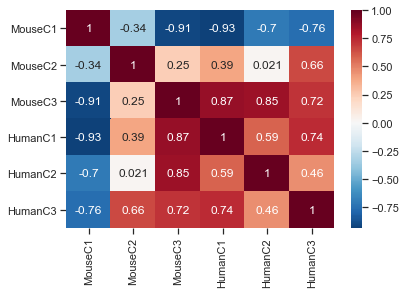

In [62]:
sns.set_context('notebook',font_scale=1)
sns.heatmap(pandas.DataFrame(np.corrcoef(spatial_exp.T),
                            index=homo.columns,columns=homo.columns),
            center=0,annot=True,cmap='RdBu_r')

# For PNC analysis

In [25]:
cexp = pandas.DataFrame(index=gdf[gdf.columns[0]])
for i in range(3):
    cexp.loc[:,'C%s'%(i+1)] = np.dot(pca_tfm.values,
                                     pls_mod.x_weights_[:,i])

In [26]:
cexp.to_csv('/Users/jacobv/Science/PLS_GXP/PNC/Genomic_Component_Expression.csv')